In [1]:
import csv
import h5py
import requests
import numpy as np
import scipy.integrate
import illustris_python as il
import matplotlib.pyplot as plt
from itertools import zip_longest
from scipy.optimize import fminbound
from hoki.csp.eventrate import CSPEventRate
from hoki.constants import BPASS_EVENT_TYPES, BPASS_METALLICITIES

In [2]:
# helper function to get subhalo data
def get(path, params=None):
    r = requests.get(path, params=params, headers={"api-key":"ac0fbfe1251d6f93c582c5490527df5d"})
    r.raise_for_status()  # raise exception if the request does not succeed (does not get HTTP code 200)
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    return r

In [3]:
# test with data.h5

In [4]:
data = h5py.File(f"./data.h5", "r")
SFH = data['SFH']['TNG']

In [5]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

In [6]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

In [7]:
redshift_indicies = ["z=0", "z=0.1", "z=0.2", "z=0.3", "z=0.4", "z=0.5", "z=1", "z=2", "z=3", "z=4", "z=5", "z=10"]
transient_types = ["Type Ia", "CCSN", "LGRB", "PISN"]

In [8]:
# Briel data

In [9]:
h = 0.6766
omega_M = 0.3111
omega_L = 0.6889
lookback_time = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years

In [10]:
SFH_input = SFH[:].reshape(1, SFH.shape[0], SFH.shape[1])*1e9  #Transform SFR from per Myr^-3 to Gpc^-3$
er_csp = CSPEventRate("./BPASS data/", imf="imf135_300", binary=True)

In [11]:
out, edges = er_csp.grid_over_time(SFH_input, lookback_time, event_types , 100, return_time_edges=True)
out = out[0]
edges = edges[:-1]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


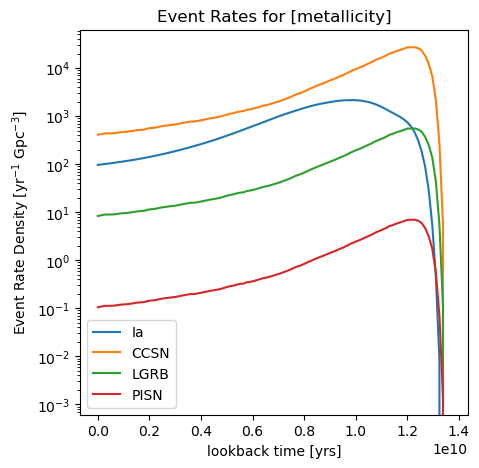

In [12]:
met_index = 4

fig = plt.figure(figsize=(5,5))
plt.plot(edges, out[:,0][met_index], label='Ia')
plt.plot(edges, out[:,1:5][met_index].sum(axis=0), label='CCSN')
plt.plot(edges, out[:,5][met_index], label='LGRB')
plt.plot(edges, out[:,6][met_index], label='PISN')

plt.yscale('log')
#plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title(r"Event Rates for [metallicity]")
plt.legend()
plt.show()

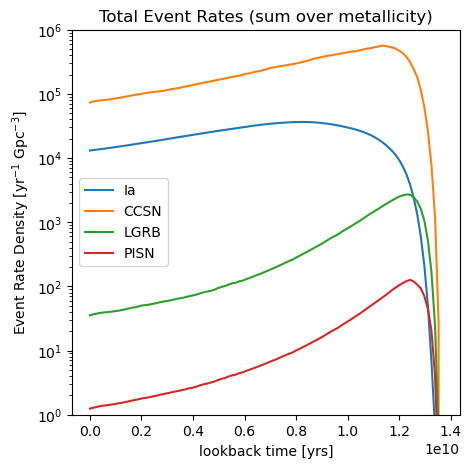

In [13]:
fig = plt.figure(figsize=(5,5))
plt.plot(edges, np.sum(out[:,0], axis=0), label='Ia')
plt.plot(edges, np.sum(out[:,1:5], axis=0).sum(axis=0), label='CCSN')
plt.plot(edges, np.sum(out[:,5], axis=0), label='LGRB')
plt.plot(edges, np.sum(out[:,6], axis=0), label='PISN')

plt.yscale('log')
plt.ylim(1e0, 1e6)
plt.xlabel('lookback time [yrs]')
plt.ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")
plt.title(r"Total Event Rates (sum over metallicity)")
plt.legend()
plt.show()

In [14]:
# TNG Data

In [15]:
# TNG cosmology
h = 0.6774
omega_M = 0.3089
omega_L = 0.6911

lookback_time99 = calc_LB(SFH.attrs['redshift'], omega_M, omega_L, h) # lookback time into years
lookback_time91 = calc_LB(SFH.attrs['redshift'][8:], omega_M, omega_L, h)
lookback_time84 = calc_LB(SFH.attrs['redshift'][15:], omega_M, omega_L, h)
lookback_time78 = calc_LB(SFH.attrs['redshift'][21:], omega_M, omega_L, h)
lookback_time72 = calc_LB(SFH.attrs['redshift'][27:], omega_M, omega_L, h)
lookback_time67 = calc_LB(SFH.attrs['redshift'][32:], omega_M, omega_L, h)
lookback_time50 = calc_LB(SFH.attrs['redshift'][49:], omega_M, omega_L, h)

In [16]:
# making event rate data for mass2

SFR2 = []
with open('./zData/mass2_99_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*139 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_99, edges2_99 = er_csp.grid_over_time(SFR2_Z, lookback_time99, event_types , 100, return_time_edges=True)
out2_99 = out2_99[0]
edges2_99 = edges2_99[:-1]

SFR2 = []
with open('./zData/mass2_91_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*128 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_91, edges2_91 = er_csp.grid_over_time(SFR2_Z, lookback_time91, event_types , 92, return_time_edges=True)
out2_91 = out2_91[0]
edges2_91 = edges2_91[:-1]

SFR2 = []
with open('./zData/mass2_84_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*127 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_84, edges2_84 = er_csp.grid_over_time(SFR2_Z, lookback_time84, event_types , 85, return_time_edges=True)
out2_84 = out2_84[0]
edges2_84 = edges2_84[:-1]

SFR2 = []
with open('./zData/mass2_78_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*123 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_78, edges2_78 = er_csp.grid_over_time(SFR2_Z, lookback_time78, event_types , 79, return_time_edges=True)
out2_78 = out2_78[0]
edges2_78 = edges2_78[:-1]

SFR2 = []
with open('./zData/mass2_72_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*111 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_72, edges2_72 = er_csp.grid_over_time(SFR2_Z, lookback_time72, event_types , 73, return_time_edges=True)
out2_72 = out2_72[0]
edges2_72 = edges2_72[:-1]

SFR2 = []
with open('./zData/mass2_67_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*98 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_67, edges2_67 = er_csp.grid_over_time(SFR2_Z, lookback_time67, event_types , 68, return_time_edges=True)
out2_67 = out2_67[0]
edges2_67 = edges2_67[:-1]

SFR2 = []
with open('./zData/mass2_50_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num)*55 for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_50, edges2_50 = er_csp.grid_over_time(SFR2_Z, lookback_time50, event_types , 51, return_time_edges=True)
out2_50 = out2_50[0]
edges2_50 = edges2_50[:-1]

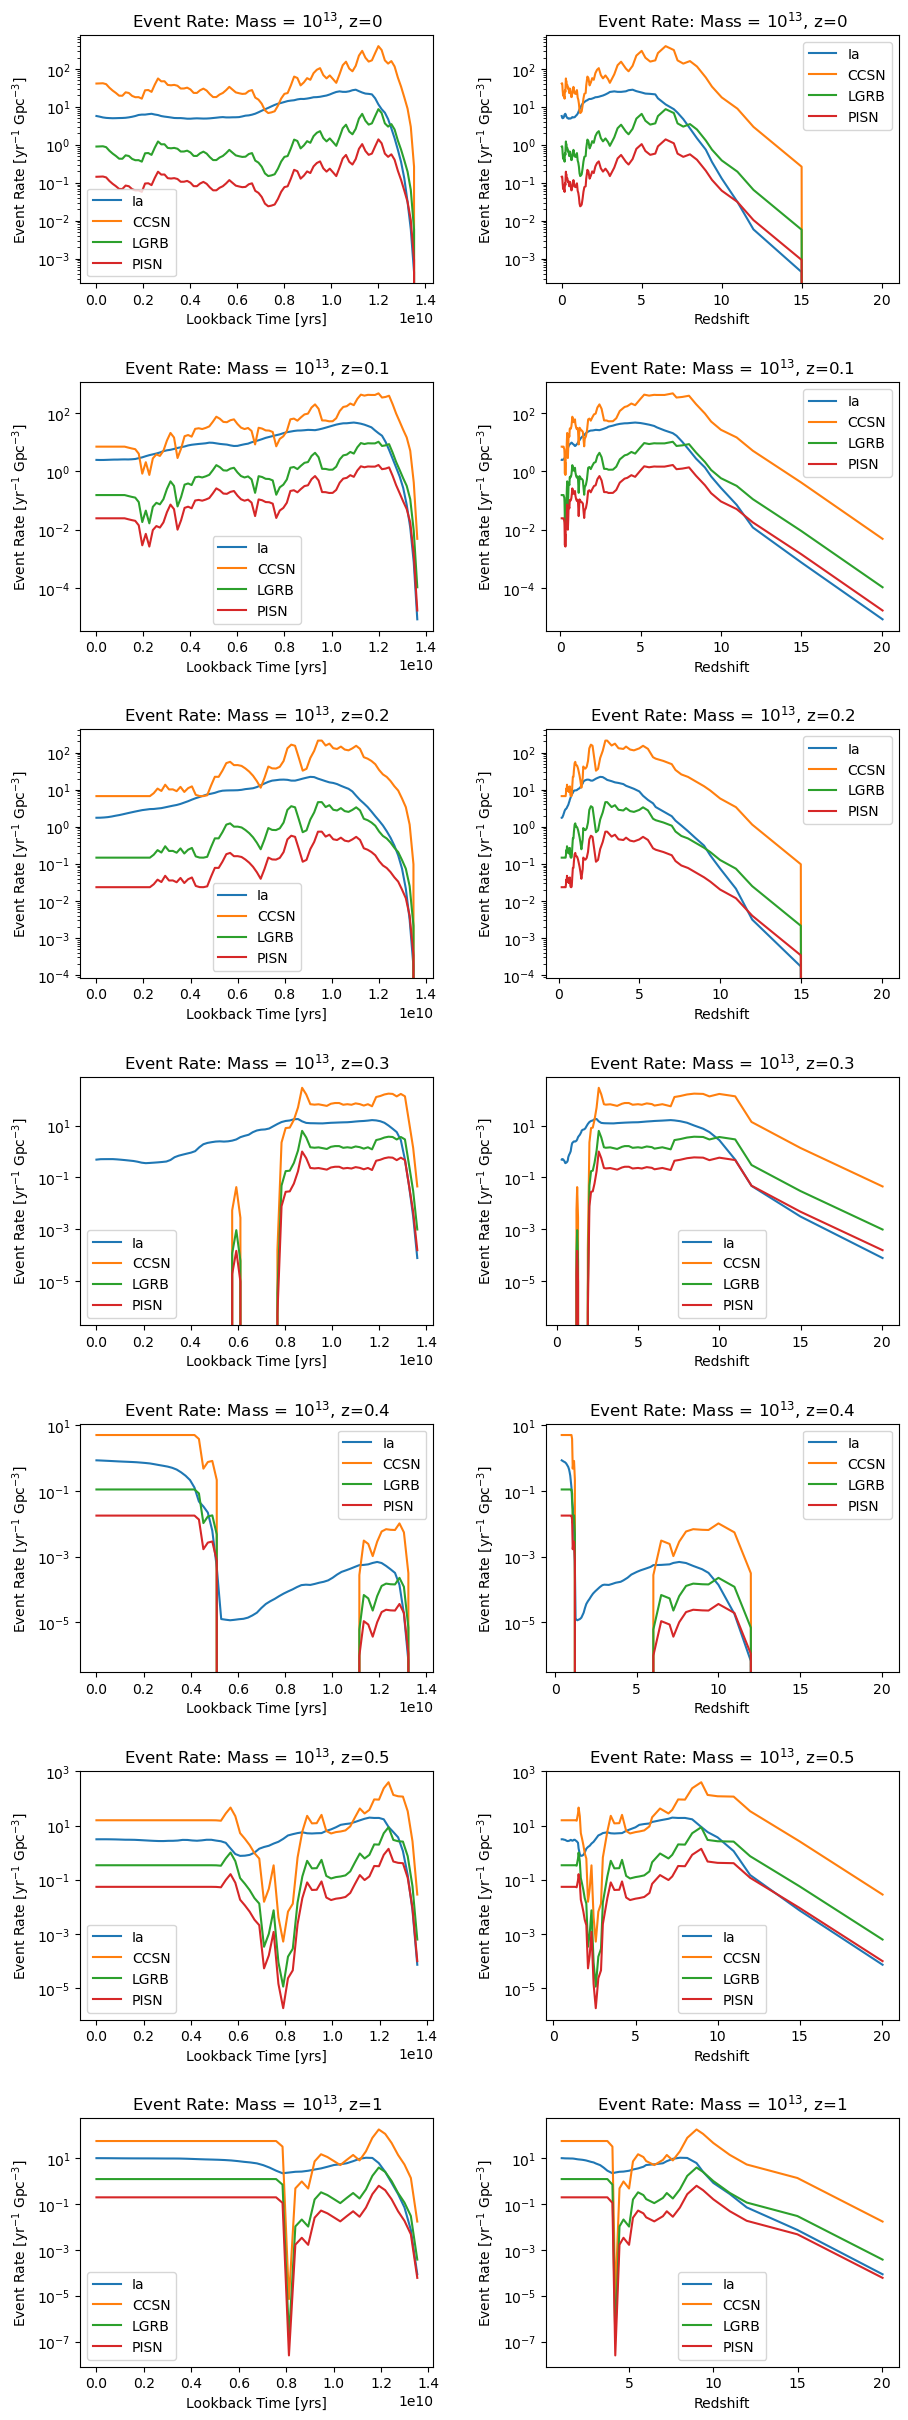

In [20]:
# plotting data for mass2 group

figure, axis = plt.subplots(7, 2, figsize=(10, 25))
figure.tight_layout(pad=5.0)

# z=99
axis[0,0].plot(edges2_99, out2_99[:,0][0], label='Ia')
axis[0,0].plot(edges2_99, out2_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges2_99, out2_99[:,5][0], label='LGRB')
axis[0,0].plot(edges2_99, out2_99[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=0")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=0")
axis[0,1].legend()

# z=91
axis[1,0].plot(edges2_91, out2_91[:,0][0], label='Ia')
axis[1,0].plot(edges2_91, out2_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges2_91, out2_91[:,5][0], label='LGRB')
axis[1,0].plot(edges2_91, out2_91[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.1")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.1")
axis[1,1].legend()

# z=84
axis[2,0].plot(edges2_84, out2_84[:,0][0], label='Ia')
axis[2,0].plot(edges2_84, out2_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges2_84, out2_84[:,5][0], label='LGRB')
axis[2,0].plot(edges2_84, out2_84[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.2")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.2")
axis[2,1].legend()

# z=78
axis[3,0].plot(edges2_78, out2_78[:,0][0], label='Ia')
axis[3,0].plot(edges2_78, out2_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges2_78, out2_78[:,5][0], label='LGRB')
axis[3,0].plot(edges2_78, out2_78[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.3")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.3")
axis[3,1].legend()

# z=72
axis[4,0].plot(edges2_72, out2_72[:,0][0], label='Ia')
axis[4,0].plot(edges2_72, out2_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,0].plot(edges2_72, out2_72[:,5][0], label='LGRB')
axis[4,0].plot(edges2_72, out2_72[:,6][0], label='PISN')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.4")
axis[4,0].legend()

axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,0][0], label='Ia')
axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,5][0], label='LGRB')
axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,6][0], label='PISN')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.4")
axis[4,1].legend()

# z=67
axis[5,0].plot(edges2_67, out2_67[:,0][0], label='Ia')
axis[5,0].plot(edges2_67, out2_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,0].plot(edges2_67, out2_67[:,5][0], label='LGRB')
axis[5,0].plot(edges2_67, out2_67[:,6][0], label='PISN')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.5")
axis[5,0].legend()

axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,0][0], label='Ia')
axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,5][0], label='LGRB')
axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,6][0], label='PISN')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=0.5")
axis[5,1].legend()

# z=50
axis[6,0].plot(edges2_50, out2_50[:,0][0], label='Ia')
axis[6,0].plot(edges2_50, out2_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,0].plot(edges2_50, out2_50[:,5][0], label='LGRB')
axis[6,0].plot(edges2_50, out2_50[:,6][0], label='PISN')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: Mass = 10$^{13}$, z=1")
axis[6,0].legend()

axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,0][0], label='Ia')
axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,5][0], label='LGRB')
axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,6][0], label='PISN')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: Mass = 10$^{13}$, z=1")
axis[6,1].legend()

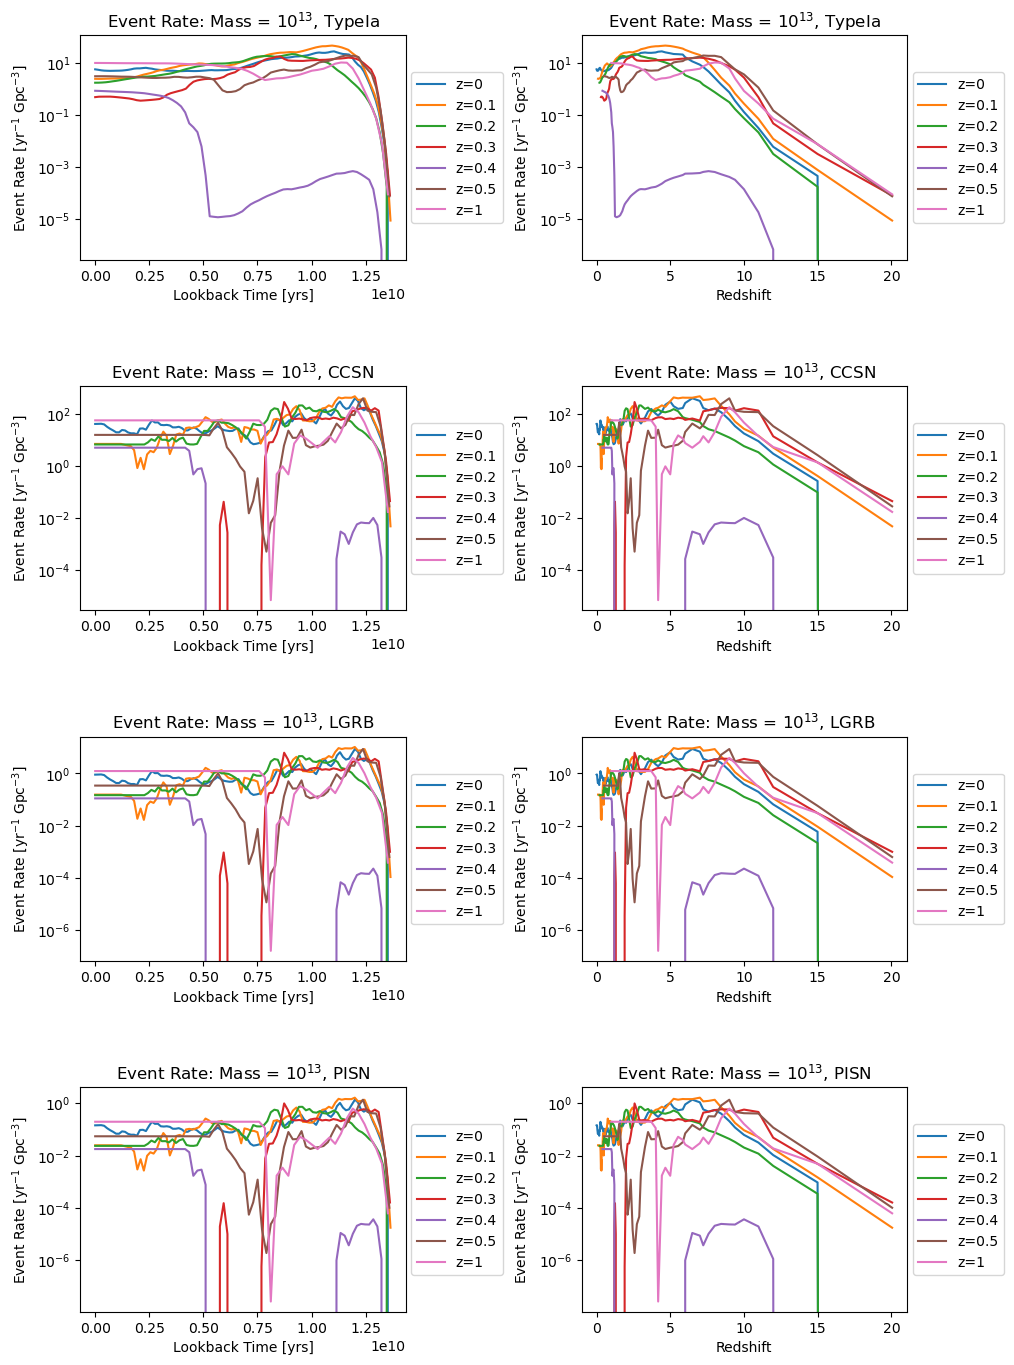

In [18]:
# comparing between redshifts for mass2

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges2_99, out2_99[:,0][0], label='z=0')
axis[0,0].plot(edges2_91, out2_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges2_84, out2_84[:,0][0], label='z=0.2')
axis[0,0].plot(edges2_78, out2_78[:,0][0], label='z=0.3')
axis[0,0].plot(edges2_72, out2_72[:,0][0], label='z=0.4')
axis[0,0].plot(edges2_67, out2_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges2_50, out2_50[:,0][0], label='z=1')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{13}$, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,0][0], label='z=0')
axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][15:], out2_84[:,0][0], label='z=0.2')
axis[0,1].plot(SFH.attrs['redshift'][21:], out2_78[:,0][0], label='z=0.3')
axis[0,1].plot(SFH.attrs['redshift'][27:], out2_72[:,0][0], label='z=0.4')
axis[0,1].plot(SFH.attrs['redshift'][32:], out2_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out2_50[:,0][0], label='z=1')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{13}$, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges2_99, out2_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,0].plot(edges2_91, out2_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges2_84, out2_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,0].plot(edges2_78, out2_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,0].plot(edges2_72, out2_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,0].plot(edges2_67, out2_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges2_50, out2_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{13}$, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'], out2_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][15:], out2_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,1].plot(SFH.attrs['redshift'][21:], out2_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,1].plot(SFH.attrs['redshift'][27:], out2_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out2_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{13}$, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges2_99, out2_99[:,5][0], label='z=0')
axis[2,0].plot(edges2_91, out2_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges2_84, out2_84[:,5][0], label='z=0.2')
axis[2,0].plot(edges2_78, out2_78[:,5][0], label='z=0.3')
axis[2,0].plot(edges2_72, out2_72[:,5][0], label='z=0.4')
axis[2,0].plot(edges2_67, out2_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges2_50, out2_50[:,5][0], label='z=1')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{13}$, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'], out2_99[:,5][0], label='z=0')
axis[2,1].plot(SFH.attrs['redshift'][8:], out2_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,5][0], label='z=0.2')
axis[2,1].plot(SFH.attrs['redshift'][21:], out2_78[:,5][0], label='z=0.3')
axis[2,1].plot(SFH.attrs['redshift'][27:], out2_72[:,5][0], label='z=0.4')
axis[2,1].plot(SFH.attrs['redshift'][32:], out2_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,5][0], label='z=1')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{13}$, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges2_99, out2_99[:,6][0], label='z=0')
axis[3,0].plot(edges2_91, out2_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges2_84, out2_84[:,6][0], label='z=0.2')
axis[3,0].plot(edges2_78, out2_78[:,6][0], label='z=0.3')
axis[3,0].plot(edges2_72, out2_72[:,6][0], label='z=0.4')
axis[3,0].plot(edges2_67, out2_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges2_50, out2_50[:,6][0], label='z=1')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{13}$, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'], out2_99[:,6][0], label='z=0')
axis[3,1].plot(SFH.attrs['redshift'][8:], out2_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][15:], out2_84[:,6][0], label='z=0.2')
axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,6][0], label='z=0.3')
axis[3,1].plot(SFH.attrs['redshift'][27:], out2_72[:,6][0], label='z=0.4')
axis[3,1].plot(SFH.attrs['redshift'][32:], out2_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out2_50[:,6][0], label='z=1')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{13}$, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [22]:
# making event rate data for mass3

SFR3 = []
with open('./zData/mass3_99_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1371 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_99, edges3_99 = er_csp.grid_over_time(SFR3_Z, lookback_time99, event_types , 100, return_time_edges=True)
out3_99 = out3_99[0]
edges3_99 = edges3_99[:-1]

SFR3 = []
with open('./zData/mass3_91_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1356 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_91, edges3_91 = er_csp.grid_over_time(SFR3_Z, lookback_time91, event_types , 92, return_time_edges=True)
out3_91 = out3_91[0]
edges3_91 = edges3_91[:-1]

SFR3 = []
with open('./zData/mass3_84_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1339 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_84, edges3_84 = er_csp.grid_over_time(SFR3_Z, lookback_time84, event_types , 85, return_time_edges=True)
out3_84 = out3_84[0]
edges3_84 = edges3_84[:-1]

SFR3 = []
with open('./zData/mass3_78_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1341 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_78, edges3_78 = er_csp.grid_over_time(SFR3_Z, lookback_time78, event_types , 79, return_time_edges=True)
out3_78 = out3_78[0]
edges3_78 = edges3_78[:-1]

SFR3 = []
with open('./zData/mass3_72_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1323 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_72, edges3_72 = er_csp.grid_over_time(SFR3_Z, lookback_time72, event_types , 73, return_time_edges=True)
out3_72 = out3_72[0]
edges3_72 = edges3_72[:-1]

SFR3 = []
with open('./zData/mass3_67_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1316 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_67, edges3_67 = er_csp.grid_over_time(SFR3_Z, lookback_time67, event_types , 68, return_time_edges=True)
out3_67 = out3_67[0]
edges3_67 = edges3_67[:-1]

SFR3 = []
with open('./zData/mass3_50_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num)*1171 for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_50, edges3_50 = er_csp.grid_over_time(SFR3_Z, lookback_time50, event_types , 51, return_time_edges=True)
out3_50 = out3_50[0]
edges3_50 = edges3_50[:-1]

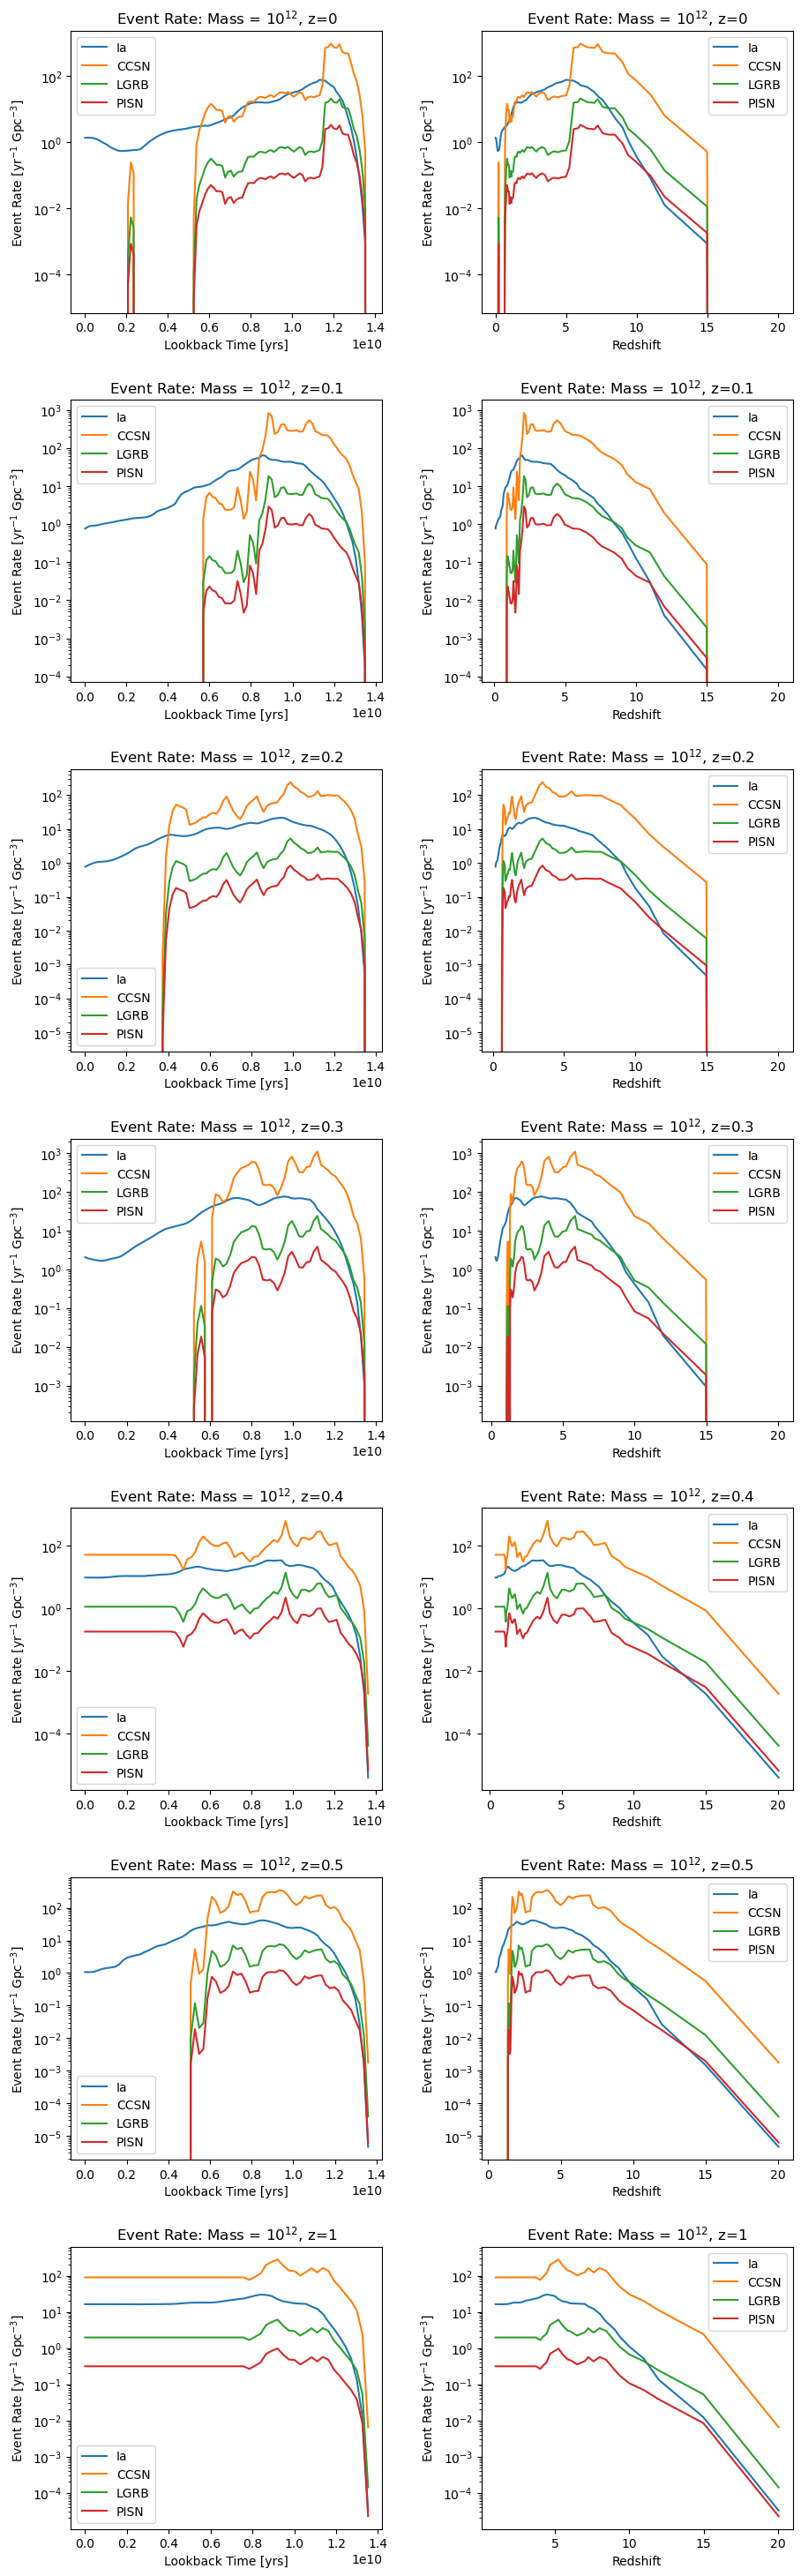

In [23]:
# plotting data for mass3 group

figure, axis = plt.subplots(7, 2, figsize=(10, 30))
figure.tight_layout(pad=5.0)

# z=99
axis[0,0].plot(edges3_99, out3_99[:,0][0], label='Ia')
axis[0,0].plot(edges3_99, out3_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges3_99, out3_99[:,5][0], label='LGRB')
axis[0,0].plot(edges3_99, out3_99[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=0")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=0")
axis[0,1].legend()

# z=91
axis[1,0].plot(edges3_91, out3_91[:,0][0], label='Ia')
axis[1,0].plot(edges3_91, out3_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges3_91, out3_91[:,5][0], label='LGRB')
axis[1,0].plot(edges3_91, out3_91[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.1")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.1")
axis[1,1].legend()

# z=84
axis[2,0].plot(edges3_84, out3_84[:,0][0], label='Ia')
axis[2,0].plot(edges3_84, out3_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges3_84, out3_84[:,5][0], label='LGRB')
axis[2,0].plot(edges3_84, out3_84[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.2")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.2")
axis[2,1].legend()

# z=78
axis[3,0].plot(edges3_78, out3_78[:,0][0], label='Ia')
axis[3,0].plot(edges3_78, out3_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges3_78, out3_78[:,5][0], label='LGRB')
axis[3,0].plot(edges3_78, out3_78[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.3")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.3")
axis[3,1].legend()

# z=72
axis[4,0].plot(edges3_72, out3_72[:,0][0], label='Ia')
axis[4,0].plot(edges3_72, out3_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,0].plot(edges3_72, out3_72[:,5][0], label='LGRB')
axis[4,0].plot(edges3_72, out3_72[:,6][0], label='PISN')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.4")
axis[4,0].legend()

axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,0][0], label='Ia')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,5][0], label='LGRB')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,6][0], label='PISN')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.4")
axis[4,1].legend()

# z=67
axis[5,0].plot(edges3_67, out3_67[:,0][0], label='Ia')
axis[5,0].plot(edges3_67, out3_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,0].plot(edges3_67, out3_67[:,5][0], label='LGRB')
axis[5,0].plot(edges3_67, out3_67[:,6][0], label='PISN')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.5")
axis[5,0].legend()

axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,0][0], label='Ia')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,5][0], label='LGRB')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,6][0], label='PISN')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=0.5")
axis[5,1].legend()

# z=50
axis[6,0].plot(edges3_50, out3_50[:,0][0], label='Ia')
axis[6,0].plot(edges3_50, out3_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,0].plot(edges3_50, out3_50[:,5][0], label='LGRB')
axis[6,0].plot(edges3_50, out3_50[:,6][0], label='PISN')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: Mass = 10$^{12}$, z=1")
axis[6,0].legend()

axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,0][0], label='Ia')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,5][0], label='LGRB')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,6][0], label='PISN')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: Mass = 10$^{12}$, z=1")
axis[6,1].legend()

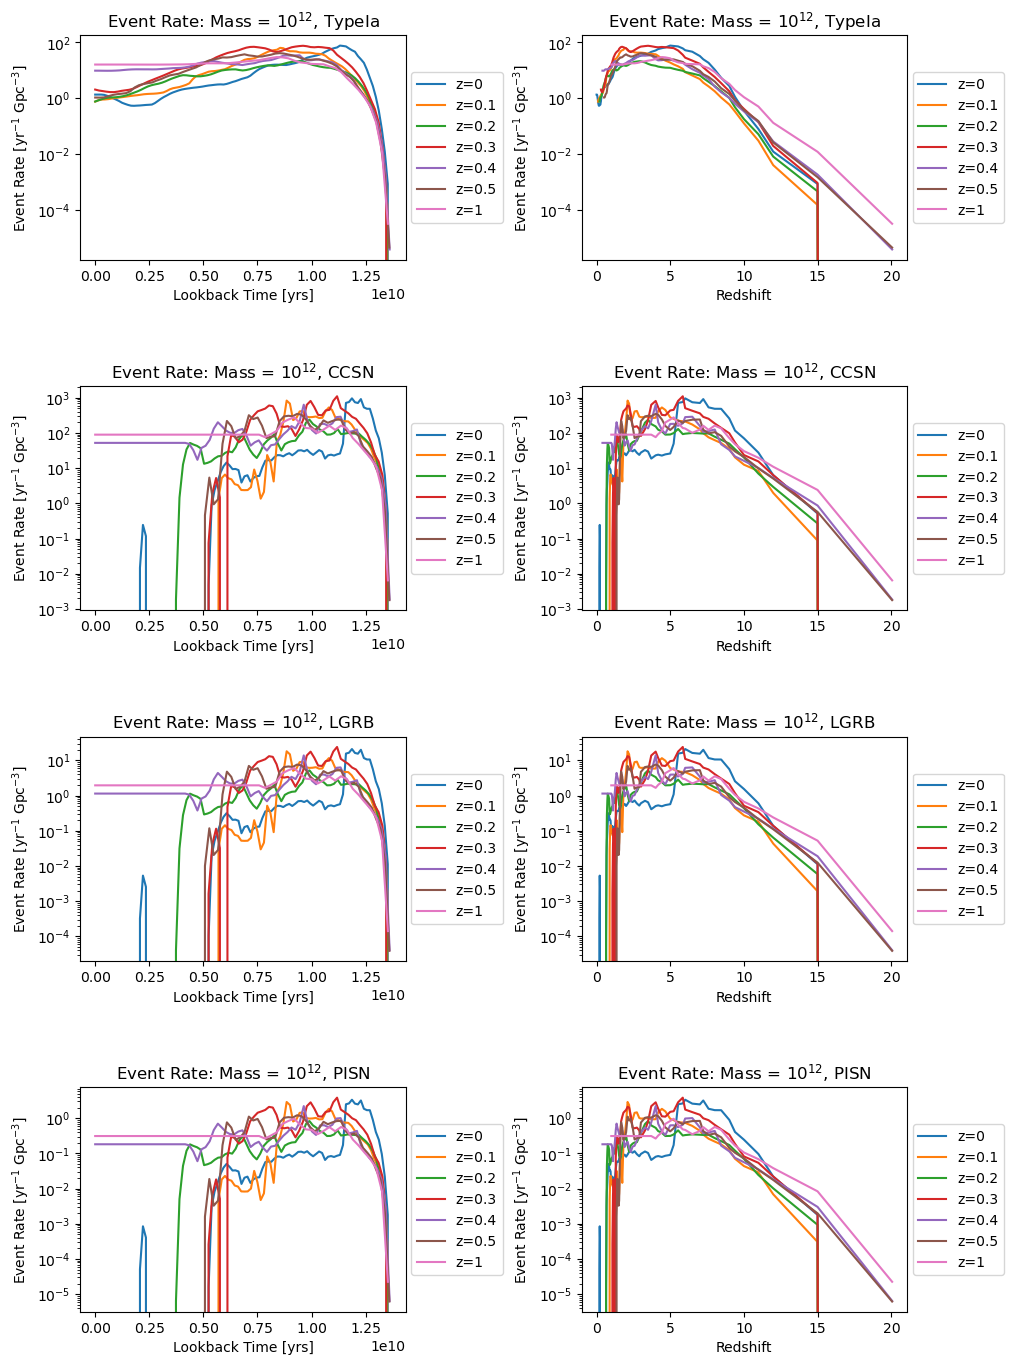

In [24]:
# comparing between redshifts for mass3

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges3_99, out3_99[:,0][0], label='z=0')
axis[0,0].plot(edges3_91, out3_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges3_84, out3_84[:,0][0], label='z=0.2')
axis[0,0].plot(edges3_78, out3_78[:,0][0], label='z=0.3')
axis[0,0].plot(edges3_72, out3_72[:,0][0], label='z=0.4')
axis[0,0].plot(edges3_67, out3_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges3_50, out3_50[:,0][0], label='z=1')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{12}$, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,0][0], label='z=0')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][15:], out3_84[:,0][0], label='z=0.2')
axis[0,1].plot(SFH.attrs['redshift'][21:], out3_78[:,0][0], label='z=0.3')
axis[0,1].plot(SFH.attrs['redshift'][27:], out3_72[:,0][0], label='z=0.4')
axis[0,1].plot(SFH.attrs['redshift'][32:], out3_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out3_50[:,0][0], label='z=1')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{12}$, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges3_99, out3_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,0].plot(edges3_91, out3_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges3_84, out3_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,0].plot(edges3_78, out3_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,0].plot(edges3_72, out3_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,0].plot(edges3_67, out3_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges3_50, out3_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{12}$, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'], out3_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][15:], out3_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,1].plot(SFH.attrs['redshift'][21:], out3_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,1].plot(SFH.attrs['redshift'][27:], out3_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out3_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{12}$, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges3_99, out3_99[:,5][0], label='z=0')
axis[2,0].plot(edges3_91, out3_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges3_84, out3_84[:,5][0], label='z=0.2')
axis[2,0].plot(edges3_78, out3_78[:,5][0], label='z=0.3')
axis[2,0].plot(edges3_72, out3_72[:,5][0], label='z=0.4')
axis[2,0].plot(edges3_67, out3_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges3_50, out3_50[:,5][0], label='z=1')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{12}$, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'], out3_99[:,5][0], label='z=0')
axis[2,1].plot(SFH.attrs['redshift'][8:], out3_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,5][0], label='z=0.2')
axis[2,1].plot(SFH.attrs['redshift'][21:], out3_78[:,5][0], label='z=0.3')
axis[2,1].plot(SFH.attrs['redshift'][27:], out3_72[:,5][0], label='z=0.4')
axis[2,1].plot(SFH.attrs['redshift'][32:], out3_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,5][0], label='z=1')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{12}$, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges3_99, out3_99[:,6][0], label='z=0')
axis[3,0].plot(edges3_91, out3_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges3_84, out3_84[:,6][0], label='z=0.2')
axis[3,0].plot(edges3_78, out3_78[:,6][0], label='z=0.3')
axis[3,0].plot(edges3_72, out3_72[:,6][0], label='z=0.4')
axis[3,0].plot(edges3_67, out3_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges3_50, out3_50[:,6][0], label='z=1')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{12}$, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'], out3_99[:,6][0], label='z=0')
axis[3,1].plot(SFH.attrs['redshift'][8:], out3_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][15:], out3_84[:,6][0], label='z=0.2')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,6][0], label='z=0.3')
axis[3,1].plot(SFH.attrs['redshift'][27:], out3_72[:,6][0], label='z=0.4')
axis[3,1].plot(SFH.attrs['redshift'][32:], out3_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out3_50[:,6][0], label='z=1')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{12}$, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [26]:
# making event rate data for mass4

SFR4 = []
with open('./zData/mass4_99_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*12271 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_99, edges4_99 = er_csp.grid_over_time(SFR4_Z, lookback_time99, event_types , 100, return_time_edges=True)
out4_99 = out4_99[0]
edges4_99 = edges4_99[:-1]

SFR4 = []
with open('./zData/mass4_91_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*12305 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_91, edges4_91 = er_csp.grid_over_time(SFR4_Z, lookback_time91, event_types , 92, return_time_edges=True)
out4_91 = out4_91[0]
edges4_91 = edges4_91[:-1]

SFR4 = []
with open('./zData/mass4_84_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*12308 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_84, edges4_84 = er_csp.grid_over_time(SFR4_Z, lookback_time84, event_types , 85, return_time_edges=True)
out4_84 = out4_84[0]
edges4_84 = edges4_84[:-1]

SFR4 = []
with open('./zData/mass4_78_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*12279 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_78, edges4_78 = er_csp.grid_over_time(SFR4_Z, lookback_time78, event_types , 79, return_time_edges=True)
out4_78 = out4_78[0]
edges4_78 = edges4_78[:-1]

SFR4 = []
with open('./zData/mass4_72_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*12208 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_72, edges4_72 = er_csp.grid_over_time(SFR4_Z, lookback_time72, event_types , 73, return_time_edges=True)
out4_72 = out4_72[0]
edges4_72 = edges4_72[:-1]

SFR4 = []
with open('./zData/mass4_67_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*12112 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_67, edges4_67 = er_csp.grid_over_time(SFR4_Z, lookback_time67, event_types , 68, return_time_edges=True)
out4_67 = out4_67[0]
edges4_67 = edges4_67[:-1]

SFR4 = []
with open('./zData/mass4_50_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num)*11594 for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_50, edges4_50 = er_csp.grid_over_time(SFR4_Z, lookback_time50, event_types , 51, return_time_edges=True)
out4_50 = out4_50[0]
edges4_50 = edges4_50[:-1]

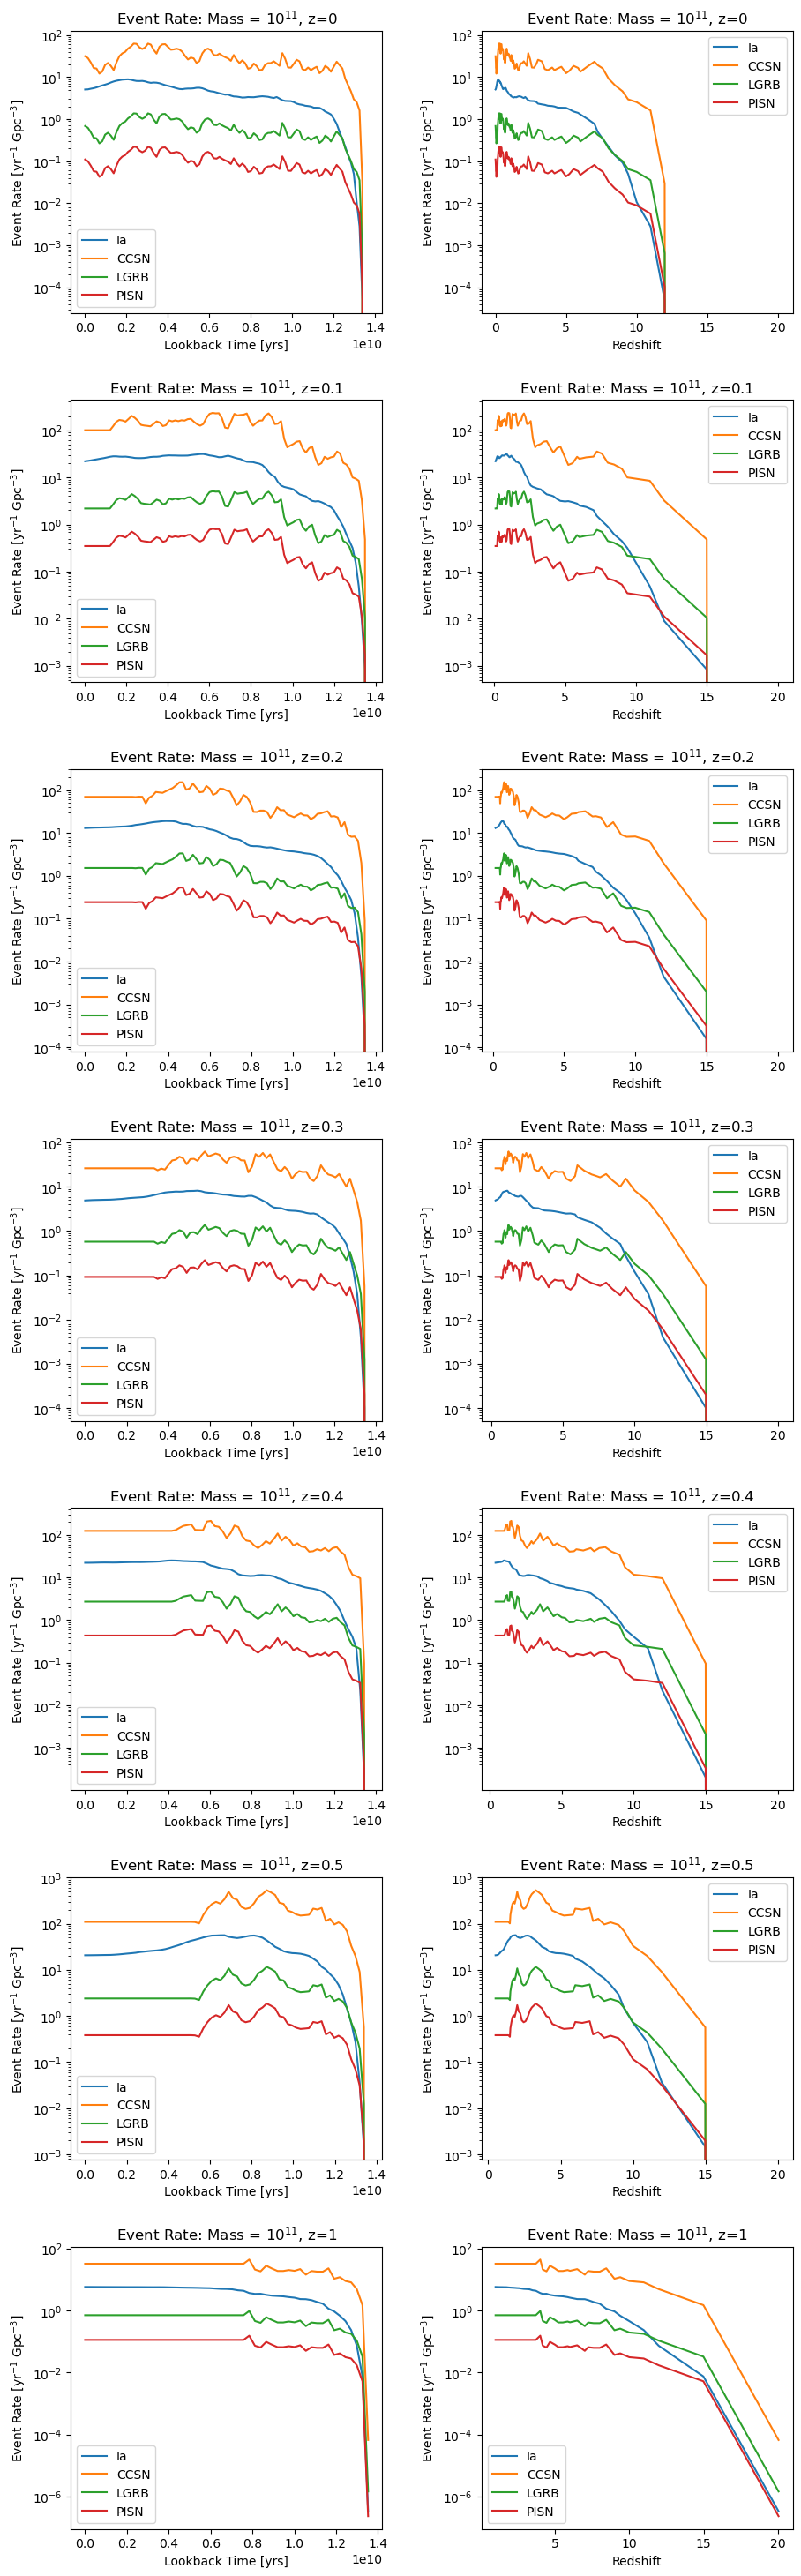

In [27]:
# plotting data for mass4 group

figure, axis = plt.subplots(7, 2, figsize=(10, 30))
figure.tight_layout(pad=5.0)

# z=99
axis[0,0].plot(edges4_99, out4_99[:,0][0], label='Ia')
axis[0,0].plot(edges4_99, out4_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges4_99, out4_99[:,5][0], label='LGRB')
axis[0,0].plot(edges4_99, out4_99[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=0")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=0")
axis[0,1].legend()

# z=91
axis[1,0].plot(edges4_91, out4_91[:,0][0], label='Ia')
axis[1,0].plot(edges4_91, out4_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges4_91, out4_91[:,5][0], label='LGRB')
axis[1,0].plot(edges4_91, out4_91[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.1")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.1")
axis[1,1].legend()

# z=84
axis[2,0].plot(edges4_84, out4_84[:,0][0], label='Ia')
axis[2,0].plot(edges4_84, out4_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges4_84, out4_84[:,5][0], label='LGRB')
axis[2,0].plot(edges4_84, out4_84[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.2")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.2")
axis[2,1].legend()

# z=78
axis[3,0].plot(edges4_78, out4_78[:,0][0], label='Ia')
axis[3,0].plot(edges4_78, out4_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges4_78, out4_78[:,5][0], label='LGRB')
axis[3,0].plot(edges4_78, out4_78[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.3")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.3")
axis[3,1].legend()

# z=72
axis[4,0].plot(edges4_72, out4_72[:,0][0], label='Ia')
axis[4,0].plot(edges4_72, out4_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,0].plot(edges4_72, out4_72[:,5][0], label='LGRB')
axis[4,0].plot(edges4_72, out4_72[:,6][0], label='PISN')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.4")
axis[4,0].legend()

axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,0][0], label='Ia')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,5][0], label='LGRB')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,6][0], label='PISN')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.4")
axis[4,1].legend()

# z=67
axis[5,0].plot(edges4_67, out4_67[:,0][0], label='Ia')
axis[5,0].plot(edges4_67, out4_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,0].plot(edges4_67, out4_67[:,5][0], label='LGRB')
axis[5,0].plot(edges4_67, out4_67[:,6][0], label='PISN')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.5")
axis[5,0].legend()

axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,0][0], label='Ia')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,5][0], label='LGRB')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,6][0], label='PISN')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=0.5")
axis[5,1].legend()

# z=50
axis[6,0].plot(edges4_50, out4_50[:,0][0], label='Ia')
axis[6,0].plot(edges4_50, out4_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,0].plot(edges4_50, out4_50[:,5][0], label='LGRB')
axis[6,0].plot(edges4_50, out4_50[:,6][0], label='PISN')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: Mass = 10$^{11}$, z=1")
axis[6,0].legend()

axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,0][0], label='Ia')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,5][0], label='LGRB')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,6][0], label='PISN')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: Mass = 10$^{11}$, z=1")
axis[6,1].legend()

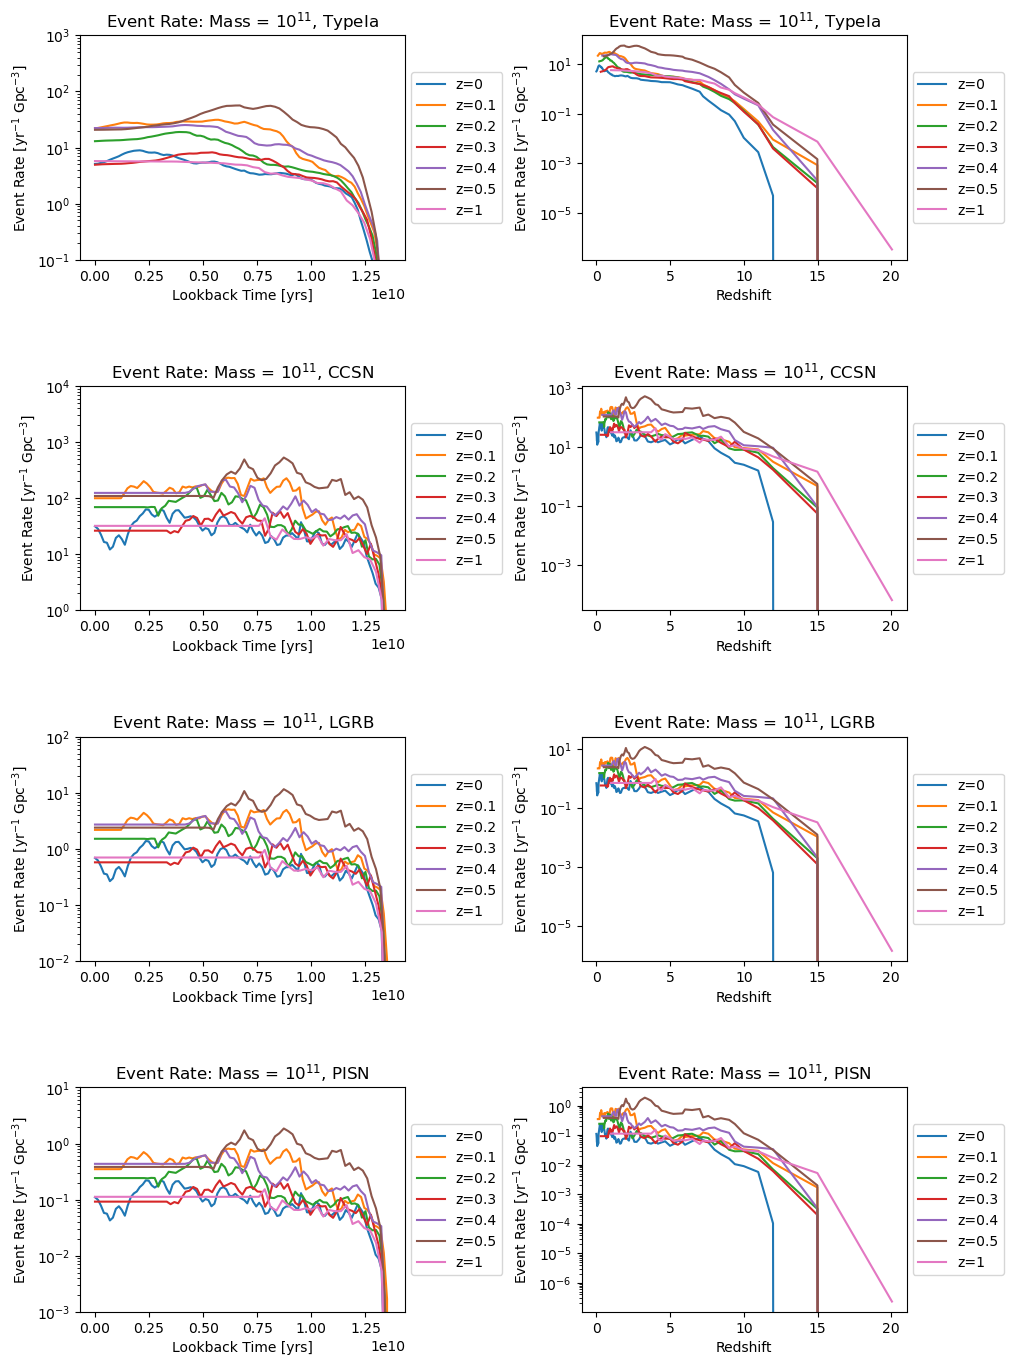

In [28]:
# comparing between redshifts for mass4

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges4_99, out4_99[:,0][0], label='z=0')
axis[0,0].plot(edges4_91, out4_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges4_84, out4_84[:,0][0], label='z=0.2')
axis[0,0].plot(edges4_78, out4_78[:,0][0], label='z=0.3')
axis[0,0].plot(edges4_72, out4_72[:,0][0], label='z=0.4')
axis[0,0].plot(edges4_67, out4_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges4_50, out4_50[:,0][0], label='z=1')
axis[0,0].set_ylim(1e-1, 1e3)
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{11}$, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,0][0], label='z=0')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][15:], out4_84[:,0][0], label='z=0.2')
axis[0,1].plot(SFH.attrs['redshift'][21:], out4_78[:,0][0], label='z=0.3')
axis[0,1].plot(SFH.attrs['redshift'][27:], out4_72[:,0][0], label='z=0.4')
axis[0,1].plot(SFH.attrs['redshift'][32:], out4_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out4_50[:,0][0], label='z=1')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{11}$, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges4_99, out4_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,0].plot(edges4_91, out4_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges4_84, out4_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,0].plot(edges4_78, out4_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,0].plot(edges4_72, out4_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,0].plot(edges4_67, out4_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges4_50, out4_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].set_ylim(1, 1e4)
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{11}$, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'], out4_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][15:], out4_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,1].plot(SFH.attrs['redshift'][21:], out4_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,1].plot(SFH.attrs['redshift'][27:], out4_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out4_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{11}$, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges4_99, out4_99[:,5][0], label='z=0')
axis[2,0].plot(edges4_91, out4_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges4_84, out4_84[:,5][0], label='z=0.2')
axis[2,0].plot(edges4_78, out4_78[:,5][0], label='z=0.3')
axis[2,0].plot(edges4_72, out4_72[:,5][0], label='z=0.4')
axis[2,0].plot(edges4_67, out4_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges4_50, out4_50[:,5][0], label='z=1')
axis[2,0].set_ylim(1e-2, 1e2)
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{11}$, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'], out4_99[:,5][0], label='z=0')
axis[2,1].plot(SFH.attrs['redshift'][8:], out4_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,5][0], label='z=0.2')
axis[2,1].plot(SFH.attrs['redshift'][21:], out4_78[:,5][0], label='z=0.3')
axis[2,1].plot(SFH.attrs['redshift'][27:], out4_72[:,5][0], label='z=0.4')
axis[2,1].plot(SFH.attrs['redshift'][32:], out4_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,5][0], label='z=1')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{11}$, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges4_99, out4_99[:,6][0], label='z=0')
axis[3,0].plot(edges4_91, out4_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges4_84, out4_84[:,6][0], label='z=0.2')
axis[3,0].plot(edges4_78, out4_78[:,6][0], label='z=0.3')
axis[3,0].plot(edges4_72, out4_72[:,6][0], label='z=0.4')
axis[3,0].plot(edges4_67, out4_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges4_50, out4_50[:,6][0], label='z=1')
axis[3,0].set_ylim(1e-3, 1e1)
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{11}$, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'], out4_99[:,6][0], label='z=0')
axis[3,1].plot(SFH.attrs['redshift'][8:], out4_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][15:], out4_84[:,6][0], label='z=0.2')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,6][0], label='z=0.3')
axis[3,1].plot(SFH.attrs['redshift'][27:], out4_72[:,6][0], label='z=0.4')
axis[3,1].plot(SFH.attrs['redshift'][32:], out4_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out4_50[:,6][0], label='z=1')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{11}$, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [29]:
# making event rate data for mass5

SFR5 = []
with open('./zData/mass5_99_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*85812 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_99, edges5_99 = er_csp.grid_over_time(SFR5_Z, lookback_time99, event_types , 100, return_time_edges=True)
out5_99 = out5_99[0]
edges5_99 = edges5_99[:-1]

SFR5 = []
with open('./zData/mass5_91_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*86196 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_91, edges5_91 = er_csp.grid_over_time(SFR5_Z, lookback_time91, event_types , 92, return_time_edges=True)
out5_91 = out5_91[0]
edges5_91 = edges5_91[:-1]

SFR5 = []
with open('./zData/mass5_84_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*86612 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_84, edges5_84 = er_csp.grid_over_time(SFR5_Z, lookback_time84, event_types , 85, return_time_edges=True)
out5_84 = out5_84[0]
edges5_84 = edges5_84[:-1]

SFR5 = []
with open('./zData/mass5_78_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*87180 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_78, edges5_78 = er_csp.grid_over_time(SFR5_Z, lookback_time78, event_types , 79, return_time_edges=True)
out5_78 = out5_78[0]
edges5_78 = edges5_78[:-1]

SFR5 = []
with open('./zData/mass5_72_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*87577 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_72, edges5_72 = er_csp.grid_over_time(SFR5_Z, lookback_time72, event_types , 73, return_time_edges=True)
out5_72 = out5_72[0]
edges5_72 = edges5_72[:-1]

SFR5 = []
with open('./zData/mass5_67_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*88132 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_67, edges5_67 = er_csp.grid_over_time(SFR5_Z, lookback_time67, event_types , 68, return_time_edges=True)
out5_67 = out5_67[0]
edges5_67 = edges5_67[:-1]

SFR5 = []
with open('./zData/mass5_50_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num)*88132 for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_50, edges5_50 = er_csp.grid_over_time(SFR5_Z, lookback_time50, event_types , 51, return_time_edges=True)
out5_50 = out5_50[0]
edges5_50 = edges5_50[:-1]

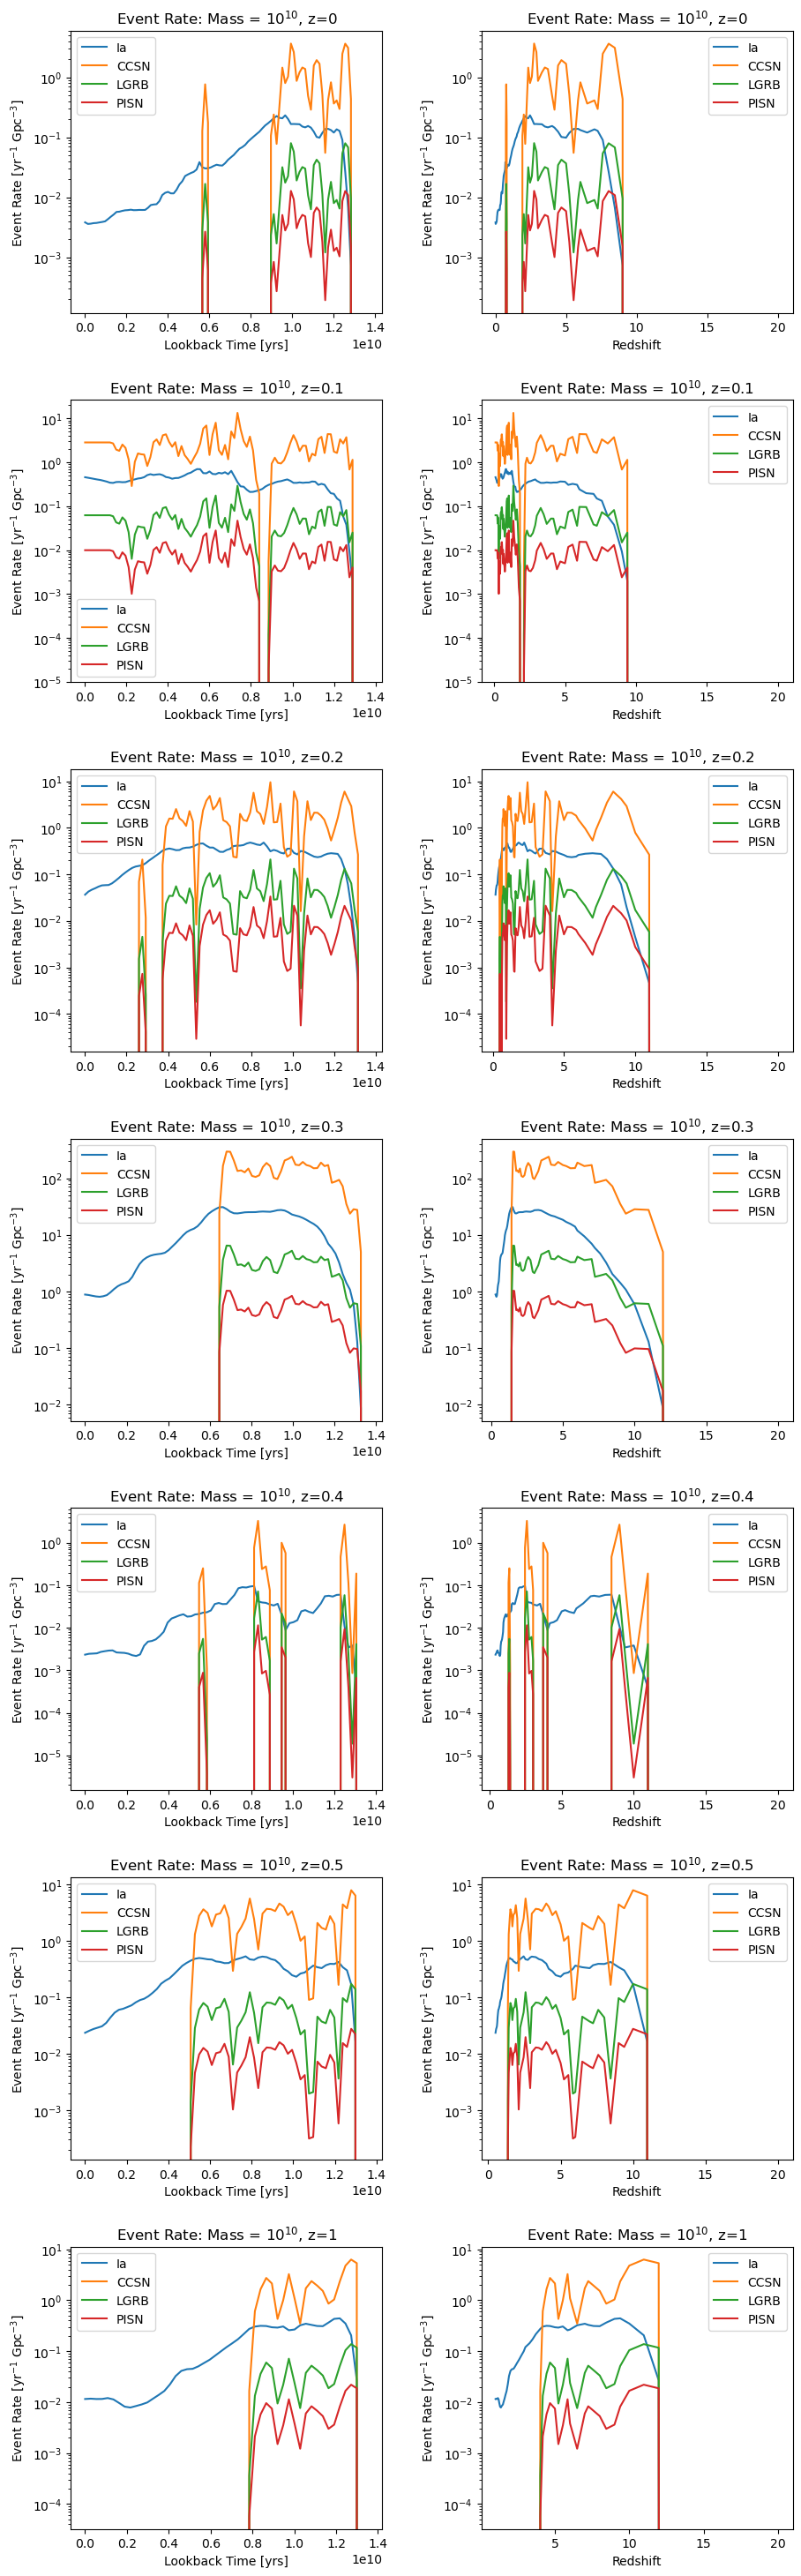

In [30]:
# plotting data for mass5 group

figure, axis = plt.subplots(7, 2, figsize=(10, 30))
figure.tight_layout(pad=5.0)

# z=99
axis[0,0].plot(edges5_99, out5_99[:,0][0], label='Ia')
axis[0,0].plot(edges5_99, out5_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges5_99, out5_99[:,5][0], label='LGRB')
axis[0,0].plot(edges5_99, out5_99[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=0")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=0")
axis[0,1].legend()

# z=91
axis[1,0].plot(edges5_91, out5_91[:,0][0], label='Ia')
axis[1,0].plot(edges5_91, out5_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges5_91, out5_91[:,5][0], label='LGRB')
axis[1,0].plot(edges5_91, out5_91[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.1")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.1")
axis[1,1].legend()

# z=84
axis[2,0].plot(edges5_84, out5_84[:,0][0], label='Ia')
axis[2,0].plot(edges5_84, out5_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges5_84, out5_84[:,5][0], label='LGRB')
axis[2,0].plot(edges5_84, out5_84[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.2")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.2")
axis[2,1].legend()

# z=78
axis[3,0].plot(edges5_78, out5_78[:,0][0], label='Ia')
axis[3,0].plot(edges5_78, out5_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges5_78, out5_78[:,5][0], label='LGRB')
axis[3,0].plot(edges5_78, out5_78[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.3")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.3")
axis[3,1].legend()

# z=72
axis[4,0].plot(edges5_72, out5_72[:,0][0], label='Ia')
axis[4,0].plot(edges5_72, out5_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,0].plot(edges5_72, out5_72[:,5][0], label='LGRB')
axis[4,0].plot(edges5_72, out5_72[:,6][0], label='PISN')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.4")
axis[4,0].legend()

axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,0][0], label='Ia')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,5][0], label='LGRB')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,6][0], label='PISN')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.4")
axis[4,1].legend()

# z=67
axis[5,0].plot(edges5_67, out5_67[:,0][0], label='Ia')
axis[5,0].plot(edges5_67, out5_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,0].plot(edges5_67, out5_67[:,5][0], label='LGRB')
axis[5,0].plot(edges5_67, out5_67[:,6][0], label='PISN')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.5")
axis[5,0].legend()

axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,0][0], label='Ia')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,5][0], label='LGRB')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,6][0], label='PISN')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=0.5")
axis[5,1].legend()

# z=50
axis[6,0].plot(edges5_50, out5_50[:,0][0], label='Ia')
axis[6,0].plot(edges5_50, out5_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,0].plot(edges5_50, out5_50[:,5][0], label='LGRB')
axis[6,0].plot(edges5_50, out5_50[:,6][0], label='PISN')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: Mass = 10$^{10}$, z=1")
axis[6,0].legend()

axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,0][0], label='Ia')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,5][0], label='LGRB')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,6][0], label='PISN')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: Mass = 10$^{10}$, z=1")
axis[6,1].legend()

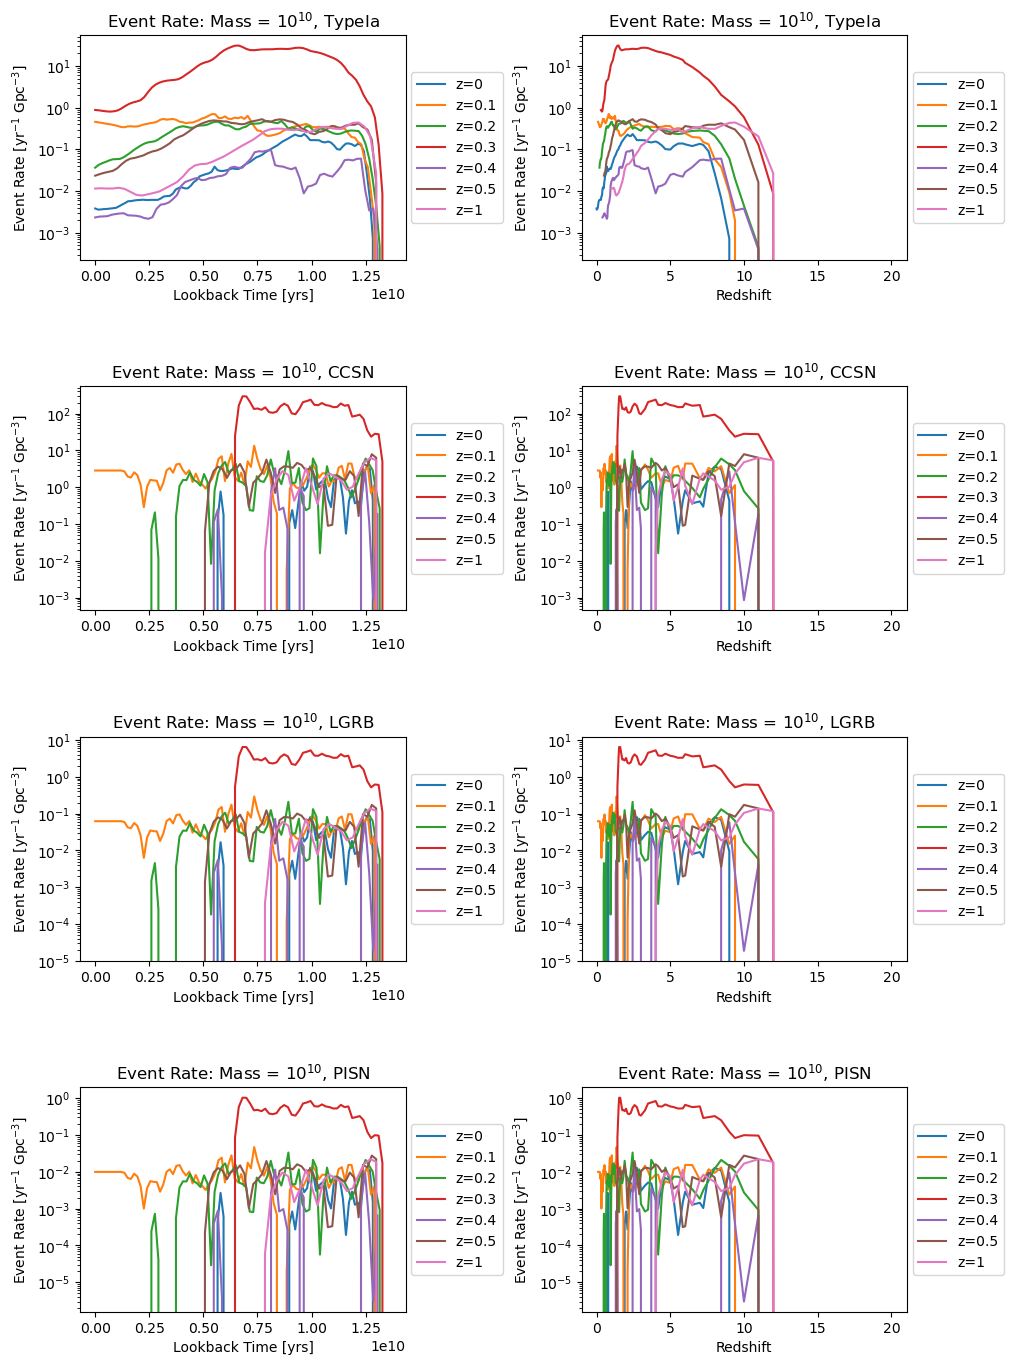

In [31]:
# comparing between redshifts for mass5

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges5_99, out5_99[:,0][0], label='z=0')
axis[0,0].plot(edges5_91, out5_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges5_84, out5_84[:,0][0], label='z=0.2')
axis[0,0].plot(edges5_78, out5_78[:,0][0], label='z=0.3')
axis[0,0].plot(edges5_72, out5_72[:,0][0], label='z=0.4')
axis[0,0].plot(edges5_67, out5_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges5_50, out5_50[:,0][0], label='z=1')
#axis[0,0].set_ylim(1e-8, 1e-2)
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{10}$, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,0][0], label='z=0')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][15:], out5_84[:,0][0], label='z=0.2')
axis[0,1].plot(SFH.attrs['redshift'][21:], out5_78[:,0][0], label='z=0.3')
axis[0,1].plot(SFH.attrs['redshift'][27:], out5_72[:,0][0], label='z=0.4')
axis[0,1].plot(SFH.attrs['redshift'][32:], out5_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out5_50[:,0][0], label='z=1')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{10}$, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges5_99, out5_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,0].plot(edges5_91, out5_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges5_84, out5_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,0].plot(edges5_78, out5_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,0].plot(edges5_72, out5_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,0].plot(edges5_67, out5_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges5_50, out5_50[:,1:5][0].sum(axis=0), label='z=1')
#axis[1,0].set_ylim(1e-5, 1)
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{10}$, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'], out5_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][15:], out5_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,1].plot(SFH.attrs['redshift'][21:], out5_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,1].plot(SFH.attrs['redshift'][27:], out5_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out5_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{10}$, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges5_99, out5_99[:,5][0], label='z=0')
axis[2,0].plot(edges5_91, out5_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges5_84, out5_84[:,5][0], label='z=0.2')
axis[2,0].plot(edges5_78, out5_78[:,5][0], label='z=0.3')
axis[2,0].plot(edges5_72, out5_72[:,5][0], label='z=0.4')
axis[2,0].plot(edges5_67, out5_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges5_50, out5_50[:,5][0], label='z=1')
#axis[2,0].set_ylim(1e-6, 1e-2)
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{10}$, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'], out5_99[:,5][0], label='z=0')
axis[2,1].plot(SFH.attrs['redshift'][8:], out5_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,5][0], label='z=0.2')
axis[2,1].plot(SFH.attrs['redshift'][21:], out5_78[:,5][0], label='z=0.3')
axis[2,1].plot(SFH.attrs['redshift'][27:], out5_72[:,5][0], label='z=0.4')
axis[2,1].plot(SFH.attrs['redshift'][32:], out5_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,5][0], label='z=1')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{10}$, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges5_99, out5_99[:,6][0], label='z=0')
axis[3,0].plot(edges5_91, out5_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges5_84, out5_84[:,6][0], label='z=0.2')
axis[3,0].plot(edges5_78, out5_78[:,6][0], label='z=0.3')
axis[3,0].plot(edges5_72, out5_72[:,6][0], label='z=0.4')
axis[3,0].plot(edges5_67, out5_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges5_50, out5_50[:,6][0], label='z=1')
#axis[3,0].set_ylim(1e-7, 1e-2)
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{10}$, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'], out5_99[:,6][0], label='z=0')
axis[3,1].plot(SFH.attrs['redshift'][8:], out5_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][15:], out5_84[:,6][0], label='z=0.2')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,6][0], label='z=0.3')
axis[3,1].plot(SFH.attrs['redshift'][27:], out5_72[:,6][0], label='z=0.4')
axis[3,1].plot(SFH.attrs['redshift'][32:], out5_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out5_50[:,6][0], label='z=1')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{10}$, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [32]:
# making event rate data for mass6

SFR6 = []
with open('./zData/mass6_99_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*650475 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_99, edges6_99 = er_csp.grid_over_time(SFR6_Z, lookback_time99, event_types , 100, return_time_edges=True)
out6_99 = out6_99[0]
edges6_99 = edges6_99[:-1]

SFR6 = []
with open('./zData/mass6_91_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*659191 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_91, edges6_91 = er_csp.grid_over_time(SFR6_Z, lookback_time91, event_types , 92, return_time_edges=True)
out6_91 = out6_91[0]
edges6_91 = edges6_91[:-1]

SFR6 = []
with open('./zData/mass6_84_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*668194 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_84, edges6_84 = er_csp.grid_over_time(SFR6_Z, lookback_time84, event_types , 85, return_time_edges=True)
out6_84 = out6_84[0]
edges6_84 = edges6_84[:-1]

SFR6 = []
with open('./zData/mass6_78_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*676557 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_78, edges6_78 = er_csp.grid_over_time(SFR6_Z, lookback_time78, event_types , 79, return_time_edges=True)
out6_78 = out6_78[0]
edges6_78 = edges6_78[:-1]

SFR6 = []
with open('./zData/mass6_72_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*685313 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_72, edges6_72 = er_csp.grid_over_time(SFR6_Z, lookback_time72, event_types , 73, return_time_edges=True)
out6_72 = out6_72[0]
edges6_72 = edges6_72[:-1]

SFR6 = []
with open('./zData/mass6_67_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*693957 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_67, edges6_67 = er_csp.grid_over_time(SFR6_Z, lookback_time67, event_types , 68, return_time_edges=True)
out6_67 = out6_67[0]
edges6_67 = edges6_67[:-1]

SFR6 = []
with open('./zData/mass6_50_v2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR6.append(row)
SFR6_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR6)):
    SFR6_Z[subhalo] = [float(num)*729551 for num in SFR6[subhalo]]
for index in range(len(SFR6_Z)):
    SFR6_Z[index] = np.array(SFR6_Z[index][::-1])
SFR6_Z = np.array([SFR6_Z])
out6_50, edges6_50 = er_csp.grid_over_time(SFR6_Z, lookback_time50, event_types , 51, return_time_edges=True)
out6_50 = out6_50[0]
edges6_50 = edges6_50[:-1]

/tmp/ipykernel_3524/250130896.py:32: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[1,0].set_yscale('log')
/tmp/ipykernel_3524/250130896.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[1,1].set_yscale('log')
/tmp/ipykernel_3524/250130896.py:53: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[2,0].set_yscale('log')
/tmp/ipykernel_3524/250130896.py:63: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[2,1].set_yscale('log')


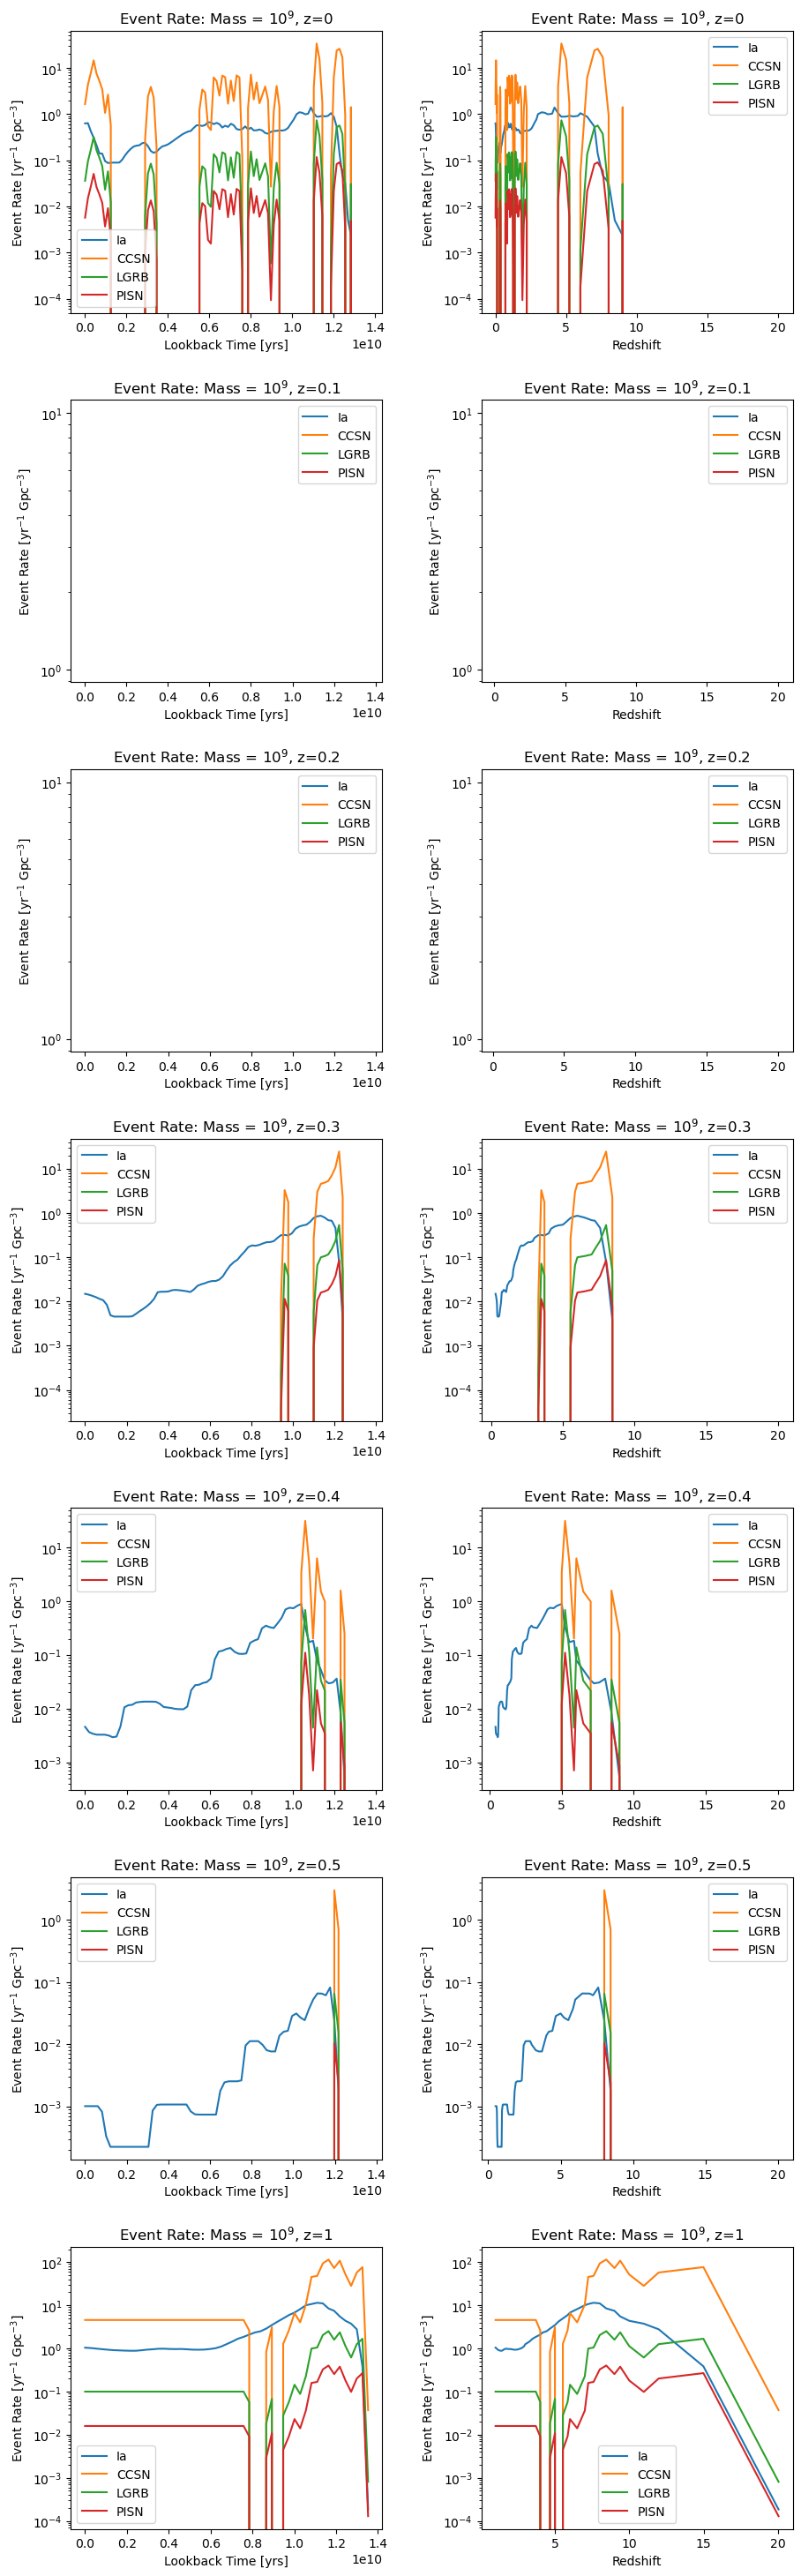

In [33]:
# plotting data for mass6 group

figure, axis = plt.subplots(7, 2, figsize=(10, 30))
figure.tight_layout(pad=5.0)

# z=99
axis[0,0].plot(edges6_99, out6_99[:,0][0], label='Ia')
axis[0,0].plot(edges6_99, out6_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges6_99, out6_99[:,5][0], label='LGRB')
axis[0,0].plot(edges6_99, out6_99[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=0")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=0")
axis[0,1].legend()

# z=91
axis[1,0].plot(edges6_91, out6_91[:,0][0], label='Ia')
axis[1,0].plot(edges6_91, out6_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges6_91, out6_91[:,5][0], label='LGRB')
axis[1,0].plot(edges6_91, out6_91[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.1")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.1")
axis[1,1].legend()

# z=84
axis[2,0].plot(edges6_84, out6_84[:,0][0], label='Ia')
axis[2,0].plot(edges6_84, out6_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges6_84, out6_84[:,5][0], label='LGRB')
axis[2,0].plot(edges6_84, out6_84[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.2")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.2")
axis[2,1].legend()

# z=78
axis[3,0].plot(edges6_78, out6_78[:,0][0], label='Ia')
axis[3,0].plot(edges6_78, out6_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges6_78, out6_78[:,5][0], label='LGRB')
axis[3,0].plot(edges6_78, out6_78[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.3")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.3")
axis[3,1].legend()

# z=72
axis[4,0].plot(edges6_72, out6_72[:,0][0], label='Ia')
axis[4,0].plot(edges6_72, out6_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,0].plot(edges6_72, out6_72[:,5][0], label='LGRB')
axis[4,0].plot(edges6_72, out6_72[:,6][0], label='PISN')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.4")
axis[4,0].legend()

axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,0][0], label='Ia')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,1:5][0].sum(axis=0), label='CCSN')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,5][0], label='LGRB')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,6][0], label='PISN')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.4")
axis[4,1].legend()

# z=67
axis[5,0].plot(edges6_67, out6_67[:,0][0], label='Ia')
axis[5,0].plot(edges6_67, out6_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,0].plot(edges6_67, out6_67[:,5][0], label='LGRB')
axis[5,0].plot(edges6_67, out6_67[:,6][0], label='PISN')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.5")
axis[5,0].legend()

axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,0][0], label='Ia')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,5][0], label='LGRB')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,6][0], label='PISN')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=0.5")
axis[5,1].legend()

# z=50
axis[6,0].plot(edges6_50, out6_50[:,0][0], label='Ia')
axis[6,0].plot(edges6_50, out6_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,0].plot(edges6_50, out6_50[:,5][0], label='LGRB')
axis[6,0].plot(edges6_50, out6_50[:,6][0], label='PISN')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: Mass = 10$^{9}$, z=1")
axis[6,0].legend()

axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,0][0], label='Ia')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,5][0], label='LGRB')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,6][0], label='PISN')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: Mass = 10$^{9}$, z=1")
axis[6,1].legend()

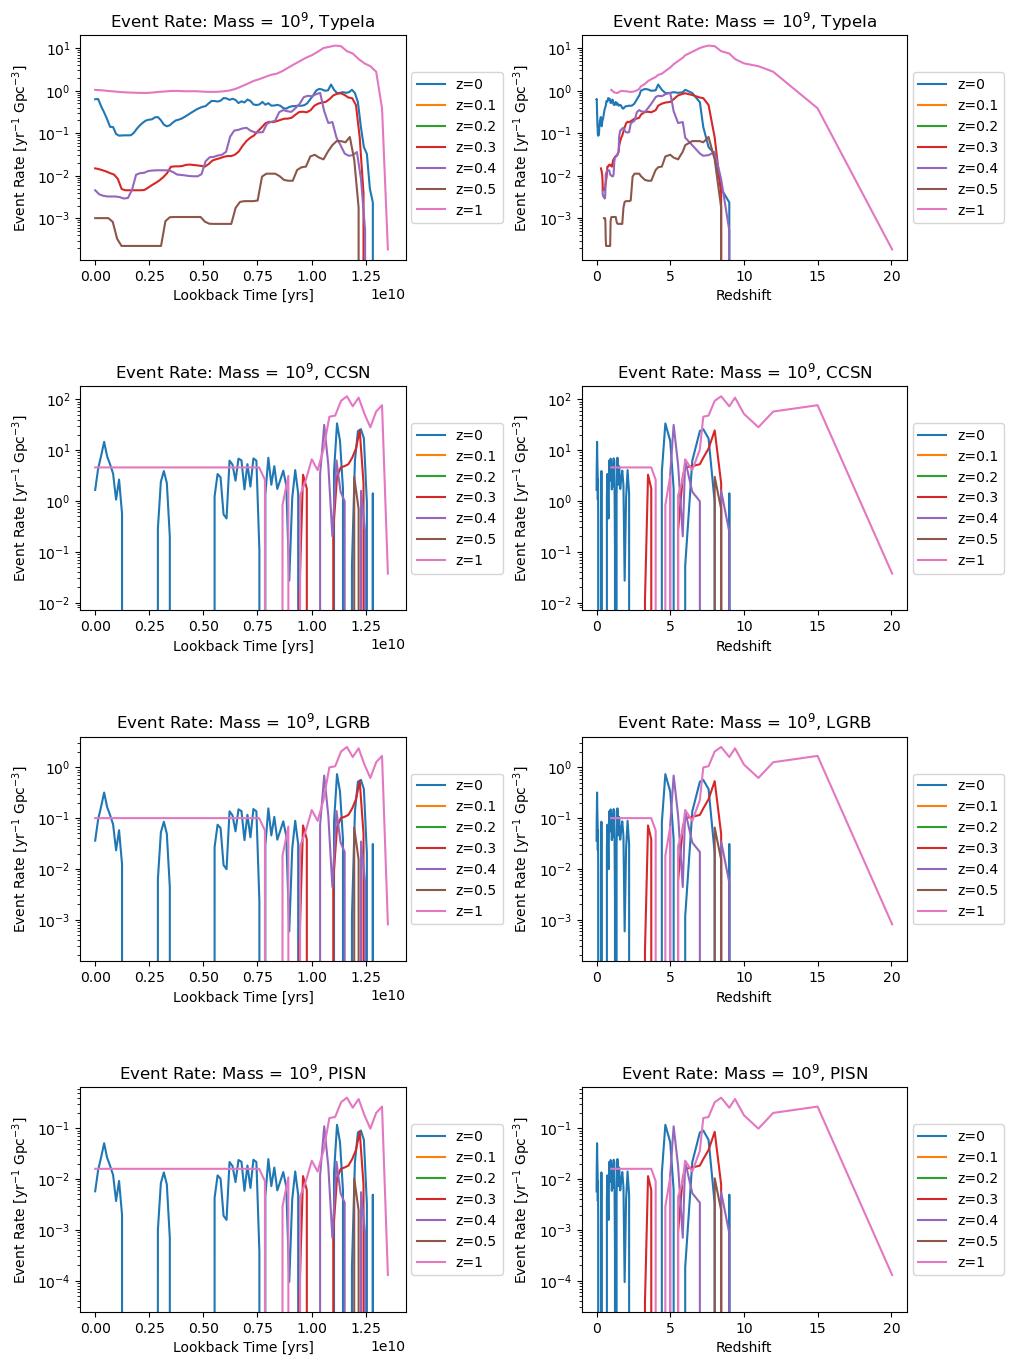

In [34]:
# comparing between redshifts for mass6

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges6_99, out6_99[:,0][0], label='z=0')
axis[0,0].plot(edges6_91, out6_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges6_84, out6_84[:,0][0], label='z=0.2')
axis[0,0].plot(edges6_78, out6_78[:,0][0], label='z=0.3')
axis[0,0].plot(edges6_72, out6_72[:,0][0], label='z=0.4')
axis[0,0].plot(edges6_67, out6_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges6_50, out6_50[:,0][0], label='z=1')
#axis[0,0].set_ylim(1e-8, 1e-2)
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: Mass = 10$^{9}$, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,0][0], label='z=0')
axis[0,1].plot(SFH.attrs['redshift'][8:], out6_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][15:], out6_84[:,0][0], label='z=0.2')
axis[0,1].plot(SFH.attrs['redshift'][21:], out6_78[:,0][0], label='z=0.3')
axis[0,1].plot(SFH.attrs['redshift'][27:], out6_72[:,0][0], label='z=0.4')
axis[0,1].plot(SFH.attrs['redshift'][32:], out6_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out6_50[:,0][0], label='z=1')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: Mass = 10$^{9}$, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges6_99, out6_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,0].plot(edges6_91, out6_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges6_84, out6_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,0].plot(edges6_78, out6_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,0].plot(edges6_72, out6_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,0].plot(edges6_67, out6_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges6_50, out6_50[:,1:5][0].sum(axis=0), label='z=1')
#axis[1,0].set_ylim(1e-5, 1)
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: Mass = 10$^{9}$, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'], out6_99[:,1:5][0].sum(axis=0), label='z=0')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][15:], out6_84[:,1:5][0].sum(axis=0), label='z=0.2')
axis[1,1].plot(SFH.attrs['redshift'][21:], out6_78[:,1:5][0].sum(axis=0), label='z=0.3')
axis[1,1].plot(SFH.attrs['redshift'][27:], out6_72[:,1:5][0].sum(axis=0), label='z=0.4')
axis[1,1].plot(SFH.attrs['redshift'][32:], out6_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out6_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: Mass = 10$^{9}$, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges6_99, out6_99[:,5][0], label='z=0')
axis[2,0].plot(edges6_91, out6_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges6_84, out6_84[:,5][0], label='z=0.2')
axis[2,0].plot(edges6_78, out6_78[:,5][0], label='z=0.3')
axis[2,0].plot(edges6_72, out6_72[:,5][0], label='z=0.4')
axis[2,0].plot(edges6_67, out6_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges6_50, out6_50[:,5][0], label='z=1')
#axis[2,0].set_ylim(1e-6, 1e-2)
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: Mass = 10$^{9}$, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'], out6_99[:,5][0], label='z=0')
axis[2,1].plot(SFH.attrs['redshift'][8:], out6_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,5][0], label='z=0.2')
axis[2,1].plot(SFH.attrs['redshift'][21:], out6_78[:,5][0], label='z=0.3')
axis[2,1].plot(SFH.attrs['redshift'][27:], out6_72[:,5][0], label='z=0.4')
axis[2,1].plot(SFH.attrs['redshift'][32:], out6_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out6_50[:,5][0], label='z=1')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: Mass = 10$^{9}$, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges6_99, out6_99[:,6][0], label='z=0')
axis[3,0].plot(edges6_91, out6_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges6_84, out6_84[:,6][0], label='z=0.2')
axis[3,0].plot(edges6_78, out6_78[:,6][0], label='z=0.3')
axis[3,0].plot(edges6_72, out6_72[:,6][0], label='z=0.4')
axis[3,0].plot(edges6_67, out6_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges6_50, out6_50[:,6][0], label='z=1')
#axis[3,0].set_ylim(1e-7, 1e-2)
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: Mass = 10$^{9}$, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'], out6_99[:,6][0], label='z=0')
axis[3,1].plot(SFH.attrs['redshift'][8:], out6_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][15:], out6_84[:,6][0], label='z=0.2')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,6][0], label='z=0.3')
axis[3,1].plot(SFH.attrs['redshift'][27:], out6_72[:,6][0], label='z=0.4')
axis[3,1].plot(SFH.attrs['redshift'][32:], out6_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out6_50[:,6][0], label='z=1')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: Mass = 10$^{9}$, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [ ]:
# Comparing transient event rates between masses

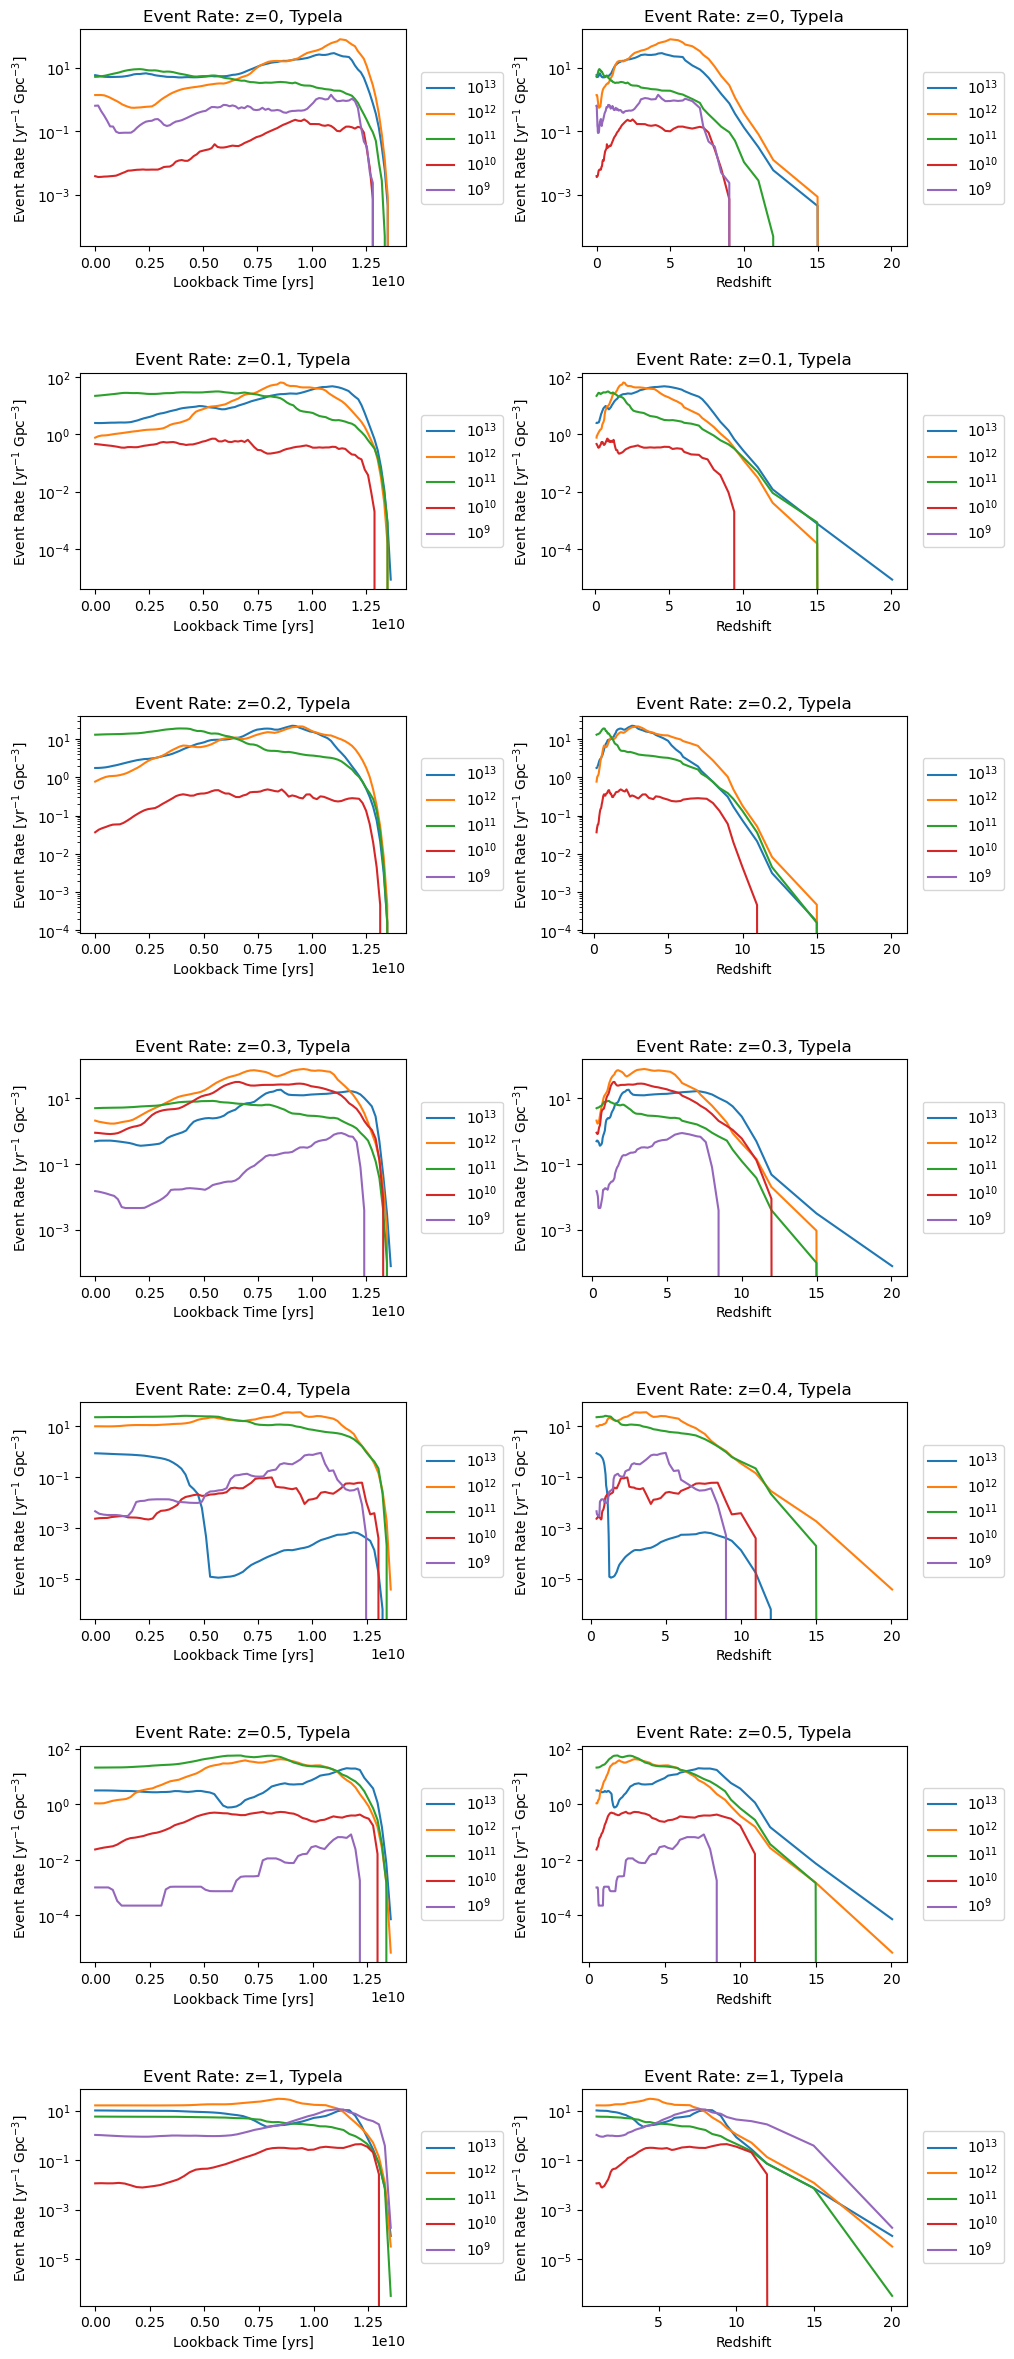

In [36]:
# typeIa

figure, axis = plt.subplots(7, 2, figsize=(11, 25))
figure.tight_layout(pad=7.0)

# z=0, snapshot=99
axis[0,0].plot(edges2_99, out2_99[:,0][0], label='10$^{13}$')
axis[0,0].plot(edges3_99, out3_99[:,0][0], label='10$^{12}$')
axis[0,0].plot(edges4_99, out4_99[:,0][0], label='10$^{11}$')
axis[0,0].plot(edges5_99, out5_99[:,0][0], label='10$^{10}$')
axis[0,0].plot(edges6_99, out6_99[:,0][0], label='10$^{9}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,0][0], label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,0][0], label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,0][0], label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,0][0], label='10$^{10}$')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,0][0], label='10$^{9}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.1, snapshot=91
axis[1,0].plot(edges2_91, out2_91[:,0][0], label='10$^{13}$')
axis[1,0].plot(edges3_91, out3_91[:,0][0], label='10$^{12}$')
axis[1,0].plot(edges4_91, out4_91[:,0][0], label='10$^{11}$')
axis[1,0].plot(edges5_91, out5_91[:,0][0], label='10$^{10}$')
axis[1,0].plot(edges6_91, out6_91[:,0][0], label='10$^{9}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.1, TypeIa")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,0][0], label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,0][0], label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,0][0], label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,0][0], label='10$^{10}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,0][0], label='10$^{9}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.1, TypeIa")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.2, snapshot=84
axis[2,0].plot(edges2_84, out2_84[:,0][0], label='10$^{13}$')
axis[2,0].plot(edges3_84, out3_84[:,0][0], label='10$^{12}$')
axis[2,0].plot(edges4_84, out4_84[:,0][0], label='10$^{11}$')
axis[2,0].plot(edges5_84, out5_84[:,0][0], label='10$^{10}$')
axis[2,0].plot(edges6_84, out6_84[:,0][0], label='10$^{9}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=0.2, TypeIa")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,0][0], label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,0][0], label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,0][0], label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,0][0], label='10$^{10}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,0][0], label='10$^{9}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=0.2, TypeIa")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.3, snapshot=78
axis[3,0].plot(edges2_78, out2_78[:,0][0], label='10$^{13}$')
axis[3,0].plot(edges3_78, out3_78[:,0][0], label='10$^{12}$')
axis[3,0].plot(edges4_78, out4_78[:,0][0], label='10$^{11}$')
axis[3,0].plot(edges5_78, out5_78[:,0][0], label='10$^{10}$')
axis[3,0].plot(edges6_78, out6_78[:,0][0], label='10$^{9}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=0.3, TypeIa")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,0][0], label='10$^{13}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,0][0], label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,0][0], label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,0][0], label='10$^{10}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,0][0], label='10$^{9}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=0.3, TypeIa")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.4, snapshot=72
axis[4,0].plot(edges2_72, out2_72[:,0][0], label='10$^{13}$')
axis[4,0].plot(edges3_72, out3_72[:,0][0], label='10$^{12}$')
axis[4,0].plot(edges4_72, out4_72[:,0][0], label='10$^{11}$')
axis[4,0].plot(edges5_72, out5_72[:,0][0], label='10$^{10}$')
axis[4,0].plot(edges6_72, out6_72[:,0][0], label='10$^{9}$')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: z=0.4, TypeIa")
pos = axis[4,0].get_position()
axis[4,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,0][0], label='10$^{13}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,0][0], label='10$^{12}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,0][0], label='10$^{11}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,0][0], label='10$^{10}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,0][0], label='10$^{9}$')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: z=0.4, TypeIa")
pos = axis[4,1].get_position()
axis[4,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[5,0].plot(edges2_67, out2_67[:,0][0], label='10$^{13}$')
axis[5,0].plot(edges3_67, out3_67[:,0][0], label='10$^{12}$')
axis[5,0].plot(edges4_67, out4_67[:,0][0], label='10$^{11}$')
axis[5,0].plot(edges5_67, out5_67[:,0][0], label='10$^{10}$')
axis[5,0].plot(edges6_67, out6_67[:,0][0], label='10$^{9}$')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: z=0.5, TypeIa")
pos = axis[5,0].get_position()
axis[5,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,0][0], label='10$^{13}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,0][0], label='10$^{12}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,0][0], label='10$^{11}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,0][0], label='10$^{10}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,0][0], label='10$^{9}$')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: z=0.5, TypeIa")
pos = axis[5,1].get_position()
axis[5,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[6,0].plot(edges2_50, out2_50[:,0][0], label='10$^{13}$')
axis[6,0].plot(edges3_50, out3_50[:,0][0], label='10$^{12}$')
axis[6,0].plot(edges4_50, out4_50[:,0][0], label='10$^{11}$')
axis[6,0].plot(edges5_50, out5_50[:,0][0], label='10$^{10}$')
axis[6,0].plot(edges6_50, out6_50[:,0][0], label='10$^{9}$')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: z=1, TypeIa")
pos = axis[6,0].get_position()
axis[6,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,0][0], label='10$^{13}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,0][0], label='10$^{12}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,0][0], label='10$^{11}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,0][0], label='10$^{10}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,0][0], label='10$^{9}$')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: z=1, TypeIa")
pos = axis[6,1].get_position()
axis[6,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

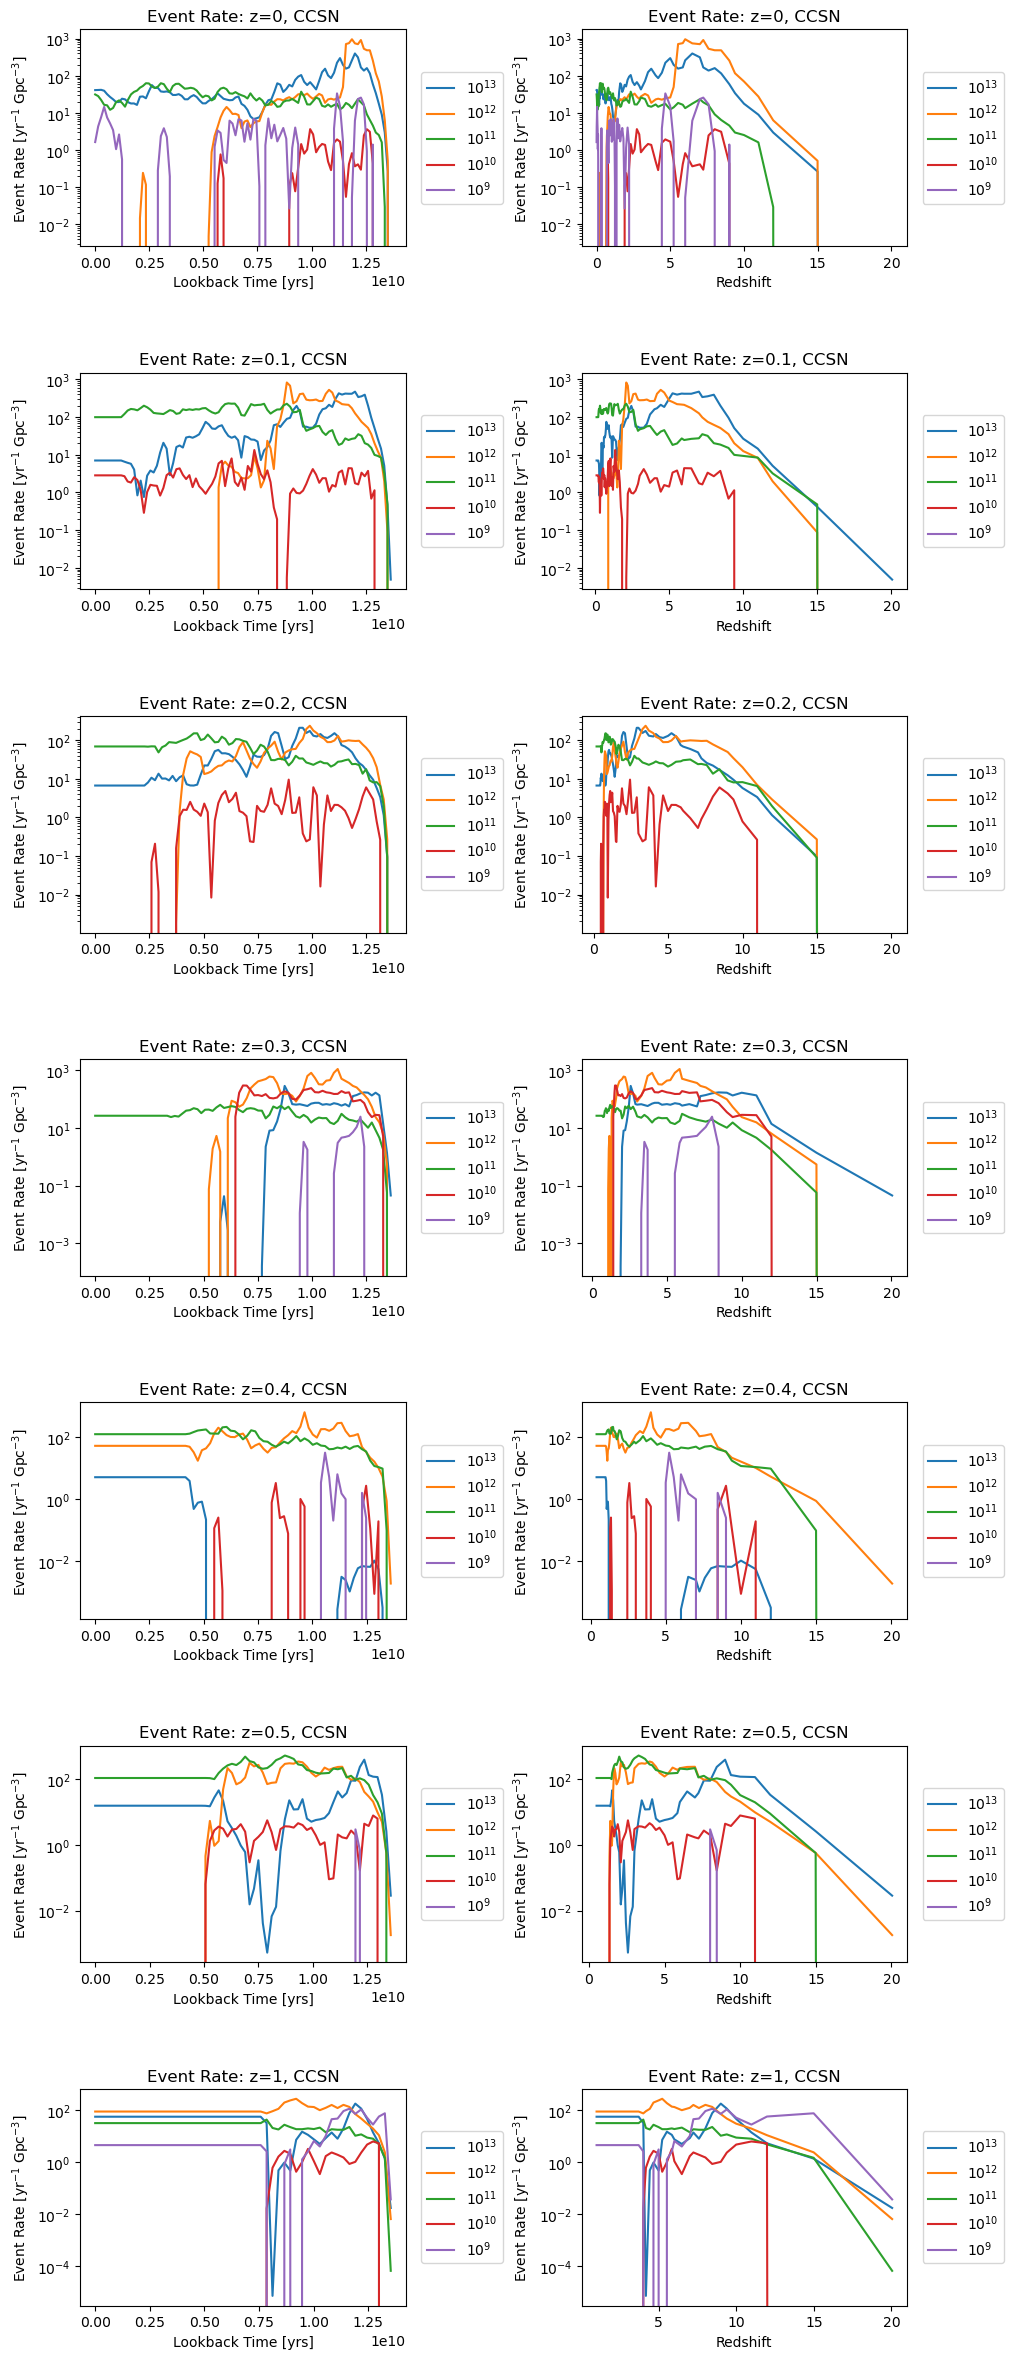

In [37]:
# CCSN

figure, axis = plt.subplots(7, 2, figsize=(11, 25))
figure.tight_layout(pad=7.0)

# z=0, snapshot=99
axis[0,0].plot(edges2_99, out2_99[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[0,0].plot(edges3_99, out3_99[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[0,0].plot(edges4_99, out4_99[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[0,0].plot(edges5_99, out5_99[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[0,0].plot(edges6_99, out6_99[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0, CCSN")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0, CCSN")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.1, snapshot=91
axis[1,0].plot(edges2_91, out2_91[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[1,0].plot(edges3_91, out3_91[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[1,0].plot(edges4_91, out4_91[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[1,0].plot(edges5_91, out5_91[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[1,0].plot(edges6_91, out6_91[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.1, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.1, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.2, snapshot=84
axis[2,0].plot(edges2_84, out2_84[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[2,0].plot(edges3_84, out3_84[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[2,0].plot(edges4_84, out4_84[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[2,0].plot(edges5_84, out5_84[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[2,0].plot(edges6_84, out6_84[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=0.2, CCSN")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=0.2, CCSN")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.3, snapshot=78
axis[3,0].plot(edges2_78, out2_78[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[3,0].plot(edges3_78, out3_78[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[3,0].plot(edges4_78, out4_78[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[3,0].plot(edges5_78, out5_78[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[3,0].plot(edges6_78, out6_78[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=0.3, CCSN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=0.3, CCSN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.4, snapshot=72
axis[4,0].plot(edges2_72, out2_72[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[4,0].plot(edges3_72, out3_72[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[4,0].plot(edges4_72, out4_72[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[4,0].plot(edges5_72, out5_72[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[4,0].plot(edges6_72, out6_72[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: z=0.4, CCSN")
pos = axis[4,0].get_position()
axis[4,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: z=0.4, CCSN")
pos = axis[4,1].get_position()
axis[4,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[5,0].plot(edges2_67, out2_67[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[5,0].plot(edges3_67, out3_67[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[5,0].plot(edges4_67, out4_67[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[5,0].plot(edges5_67, out5_67[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[5,0].plot(edges6_67, out6_67[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: z=0.5, CCSN")
pos = axis[5,0].get_position()
axis[5,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: z=0.5, CCSN")
pos = axis[5,1].get_position()
axis[5,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[6,0].plot(edges2_50, out2_50[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[6,0].plot(edges3_50, out3_50[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[6,0].plot(edges4_50, out4_50[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[6,0].plot(edges5_50, out5_50[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[6,0].plot(edges6_50, out6_50[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: z=1, CCSN")
pos = axis[6,0].get_position()
axis[6,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,1:5][0].sum(axis=0), label='10$^{9}$')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: z=1, CCSN")
pos = axis[6,1].get_position()
axis[6,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

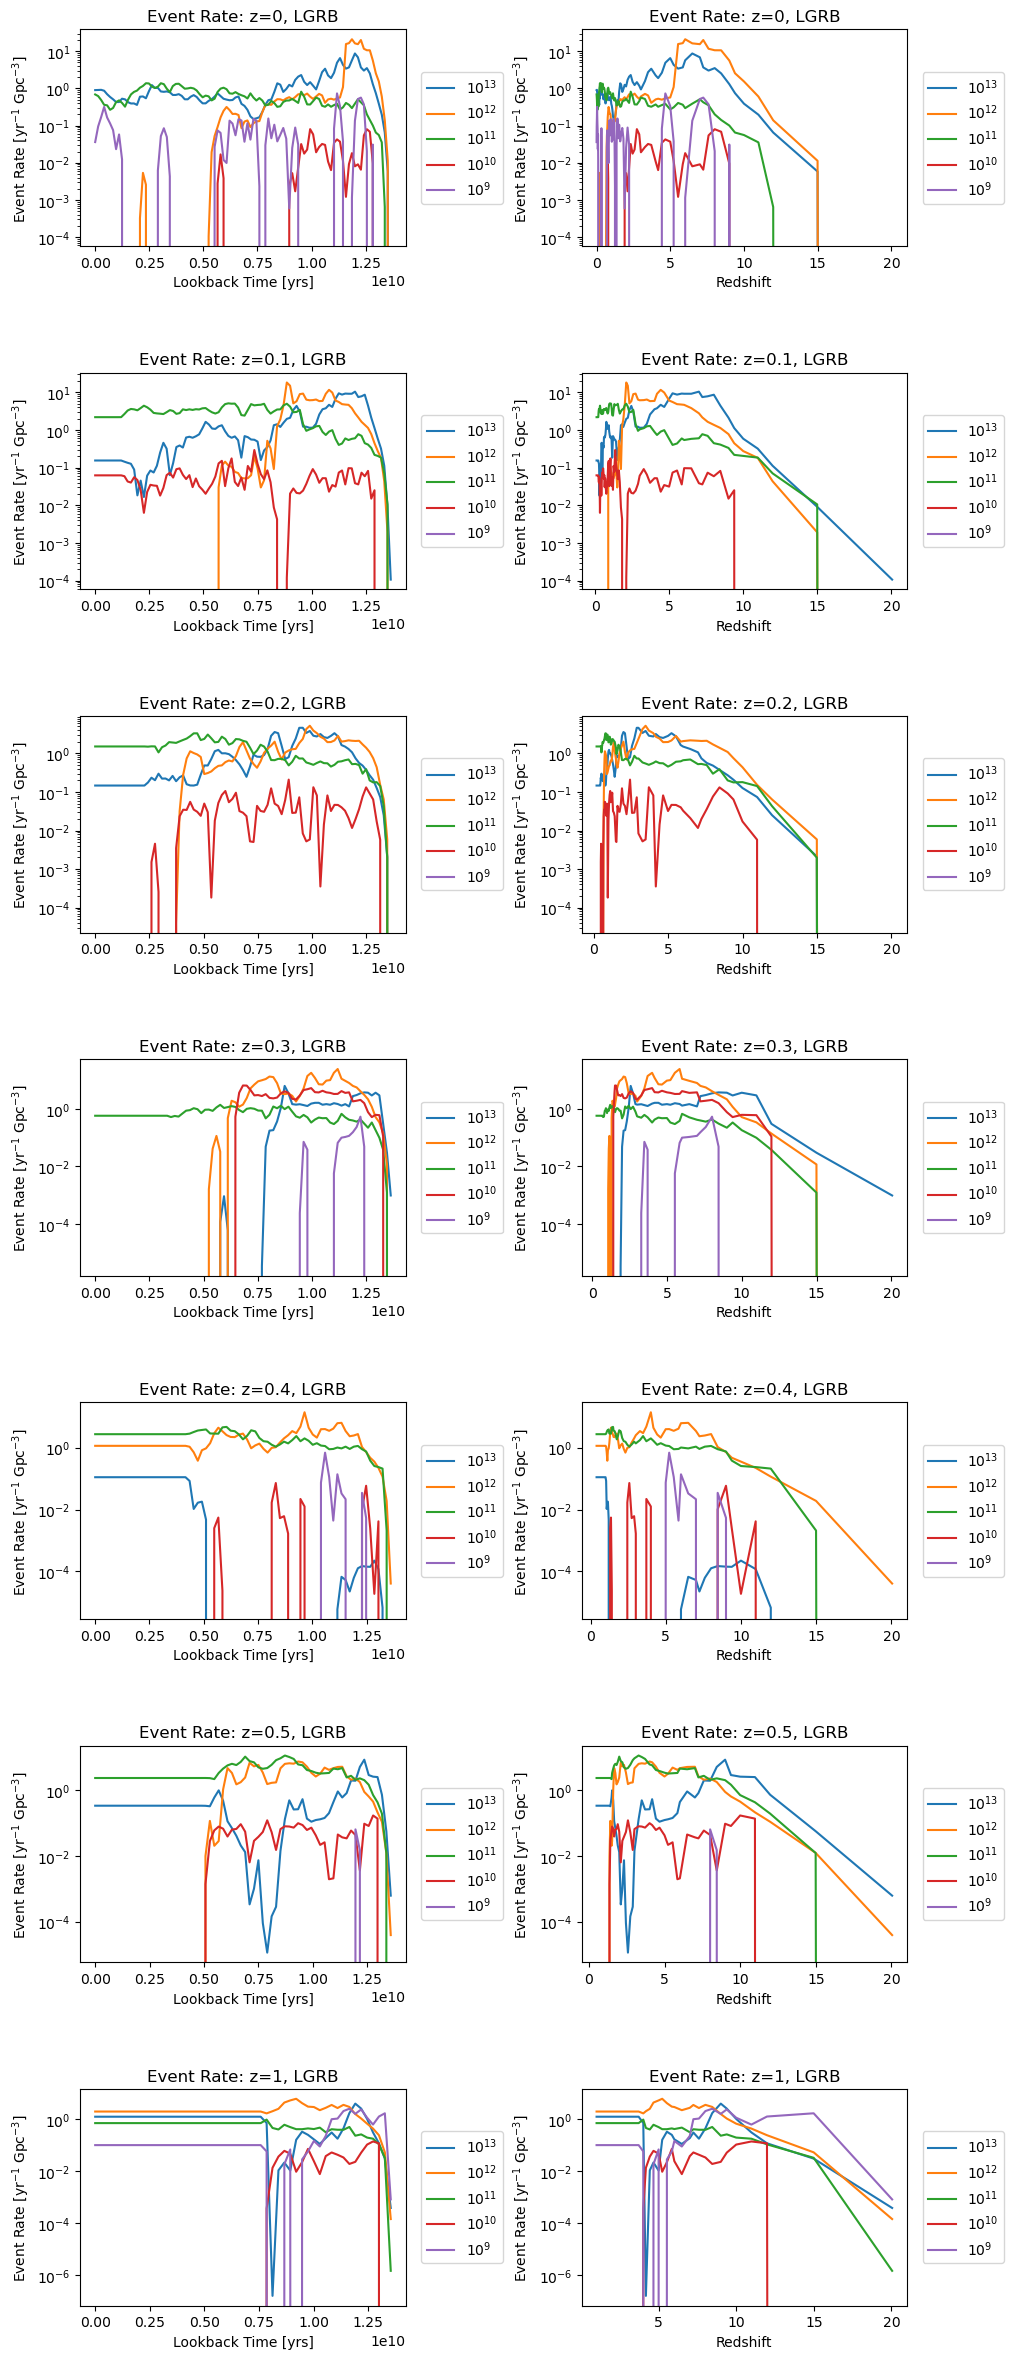

In [38]:
# LGRB

figure, axis = plt.subplots(7, 2, figsize=(11, 25))
figure.tight_layout(pad=7.0)

# z=0, snapshot=99
axis[0,0].plot(edges2_99, out2_99[:,5][0], label='10$^{13}$')
axis[0,0].plot(edges3_99, out3_99[:,5][0], label='10$^{12}$')
axis[0,0].plot(edges4_99, out4_99[:,5][0], label='10$^{11}$')
axis[0,0].plot(edges5_99, out5_99[:,5][0], label='10$^{10}$')
axis[0,0].plot(edges6_99, out6_99[:,5][0], label='10$^{9}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0, LGRB")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,5][0], label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,5][0], label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,5][0], label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,5][0], label='10$^{10}$')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,5][0], label='10$^{9}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0, LGRB")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.1, snapshot=91
axis[1,0].plot(edges2_91, out2_91[:,5][0], label='10$^{13}$')
axis[1,0].plot(edges3_91, out3_91[:,5][0], label='10$^{12}$')
axis[1,0].plot(edges4_91, out4_91[:,5][0], label='10$^{11}$')
axis[1,0].plot(edges5_91, out5_91[:,5][0], label='10$^{10}$')
axis[1,0].plot(edges6_91, out6_91[:,5][0], label='10$^{9}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.1, LGRB")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,5][0], label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,5][0], label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,5][0], label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,5][0], label='10$^{10}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,5][0], label='10$^{9}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.1, LGRB")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.2, snapshot=84
axis[2,0].plot(edges2_84, out2_84[:,5][0], label='10$^{13}$')
axis[2,0].plot(edges3_84, out3_84[:,5][0], label='10$^{12}$')
axis[2,0].plot(edges4_84, out4_84[:,5][0], label='10$^{11}$')
axis[2,0].plot(edges5_84, out5_84[:,5][0], label='10$^{10}$')
axis[2,0].plot(edges6_84, out6_84[:,5][0], label='10$^{9}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=0.2, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,5][0], label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,5][0], label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,5][0], label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,5][0], label='10$^{10}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,5][0], label='10$^{9}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=0.2, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.3, snapshot=78
axis[3,0].plot(edges2_78, out2_78[:,5][0], label='10$^{13}$')
axis[3,0].plot(edges3_78, out3_78[:,5][0], label='10$^{12}$')
axis[3,0].plot(edges4_78, out4_78[:,5][0], label='10$^{11}$')
axis[3,0].plot(edges5_78, out5_78[:,5][0], label='10$^{10}$')
axis[3,0].plot(edges6_78, out6_78[:,5][0], label='10$^{9}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=0.3, LGRB")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,5][0], label='10$^{13}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,5][0], label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,5][0], label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,5][0], label='10$^{10}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,5][0], label='10$^{9}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=0.3, LGRB")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.4, snapshot=72
axis[4,0].plot(edges2_72, out2_72[:,5][0], label='10$^{13}$')
axis[4,0].plot(edges3_72, out3_72[:,5][0], label='10$^{12}$')
axis[4,0].plot(edges4_72, out4_72[:,5][0], label='10$^{11}$')
axis[4,0].plot(edges5_72, out5_72[:,5][0], label='10$^{10}$')
axis[4,0].plot(edges6_72, out6_72[:,5][0], label='10$^{9}$')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: z=0.4, LGRB")
pos = axis[4,0].get_position()
axis[4,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,5][0], label='10$^{13}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,5][0], label='10$^{12}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,5][0], label='10$^{11}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,5][0], label='10$^{10}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,5][0], label='10$^{9}$')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: z=0.4, LGRB")
pos = axis[4,1].get_position()
axis[4,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[5,0].plot(edges2_67, out2_67[:,5][0], label='10$^{13}$')
axis[5,0].plot(edges3_67, out3_67[:,5][0], label='10$^{12}$')
axis[5,0].plot(edges4_67, out4_67[:,5][0], label='10$^{11}$')
axis[5,0].plot(edges5_67, out5_67[:,5][0], label='10$^{10}$')
axis[5,0].plot(edges6_67, out6_67[:,5][0], label='10$^{9}$')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: z=0.5, LGRB")
pos = axis[5,0].get_position()
axis[5,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,5][0], label='10$^{13}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,5][0], label='10$^{12}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,5][0], label='10$^{11}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,5][0], label='10$^{10}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,5][0], label='10$^{9}$')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: z=0.5, LGRB")
pos = axis[5,1].get_position()
axis[5,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[6,0].plot(edges2_50, out2_50[:,5][0], label='10$^{13}$')
axis[6,0].plot(edges3_50, out3_50[:,5][0], label='10$^{12}$')
axis[6,0].plot(edges4_50, out4_50[:,5][0], label='10$^{11}$')
axis[6,0].plot(edges5_50, out5_50[:,5][0], label='10$^{10}$')
axis[6,0].plot(edges6_50, out6_50[:,5][0], label='10$^{9}$')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: z=1, LGRB")
pos = axis[6,0].get_position()
axis[6,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,5][0], label='10$^{13}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,5][0], label='10$^{12}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,5][0], label='10$^{11}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,5][0], label='10$^{10}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,5][0], label='10$^{9}$')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: z=1, LGRB")
pos = axis[6,1].get_position()
axis[6,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

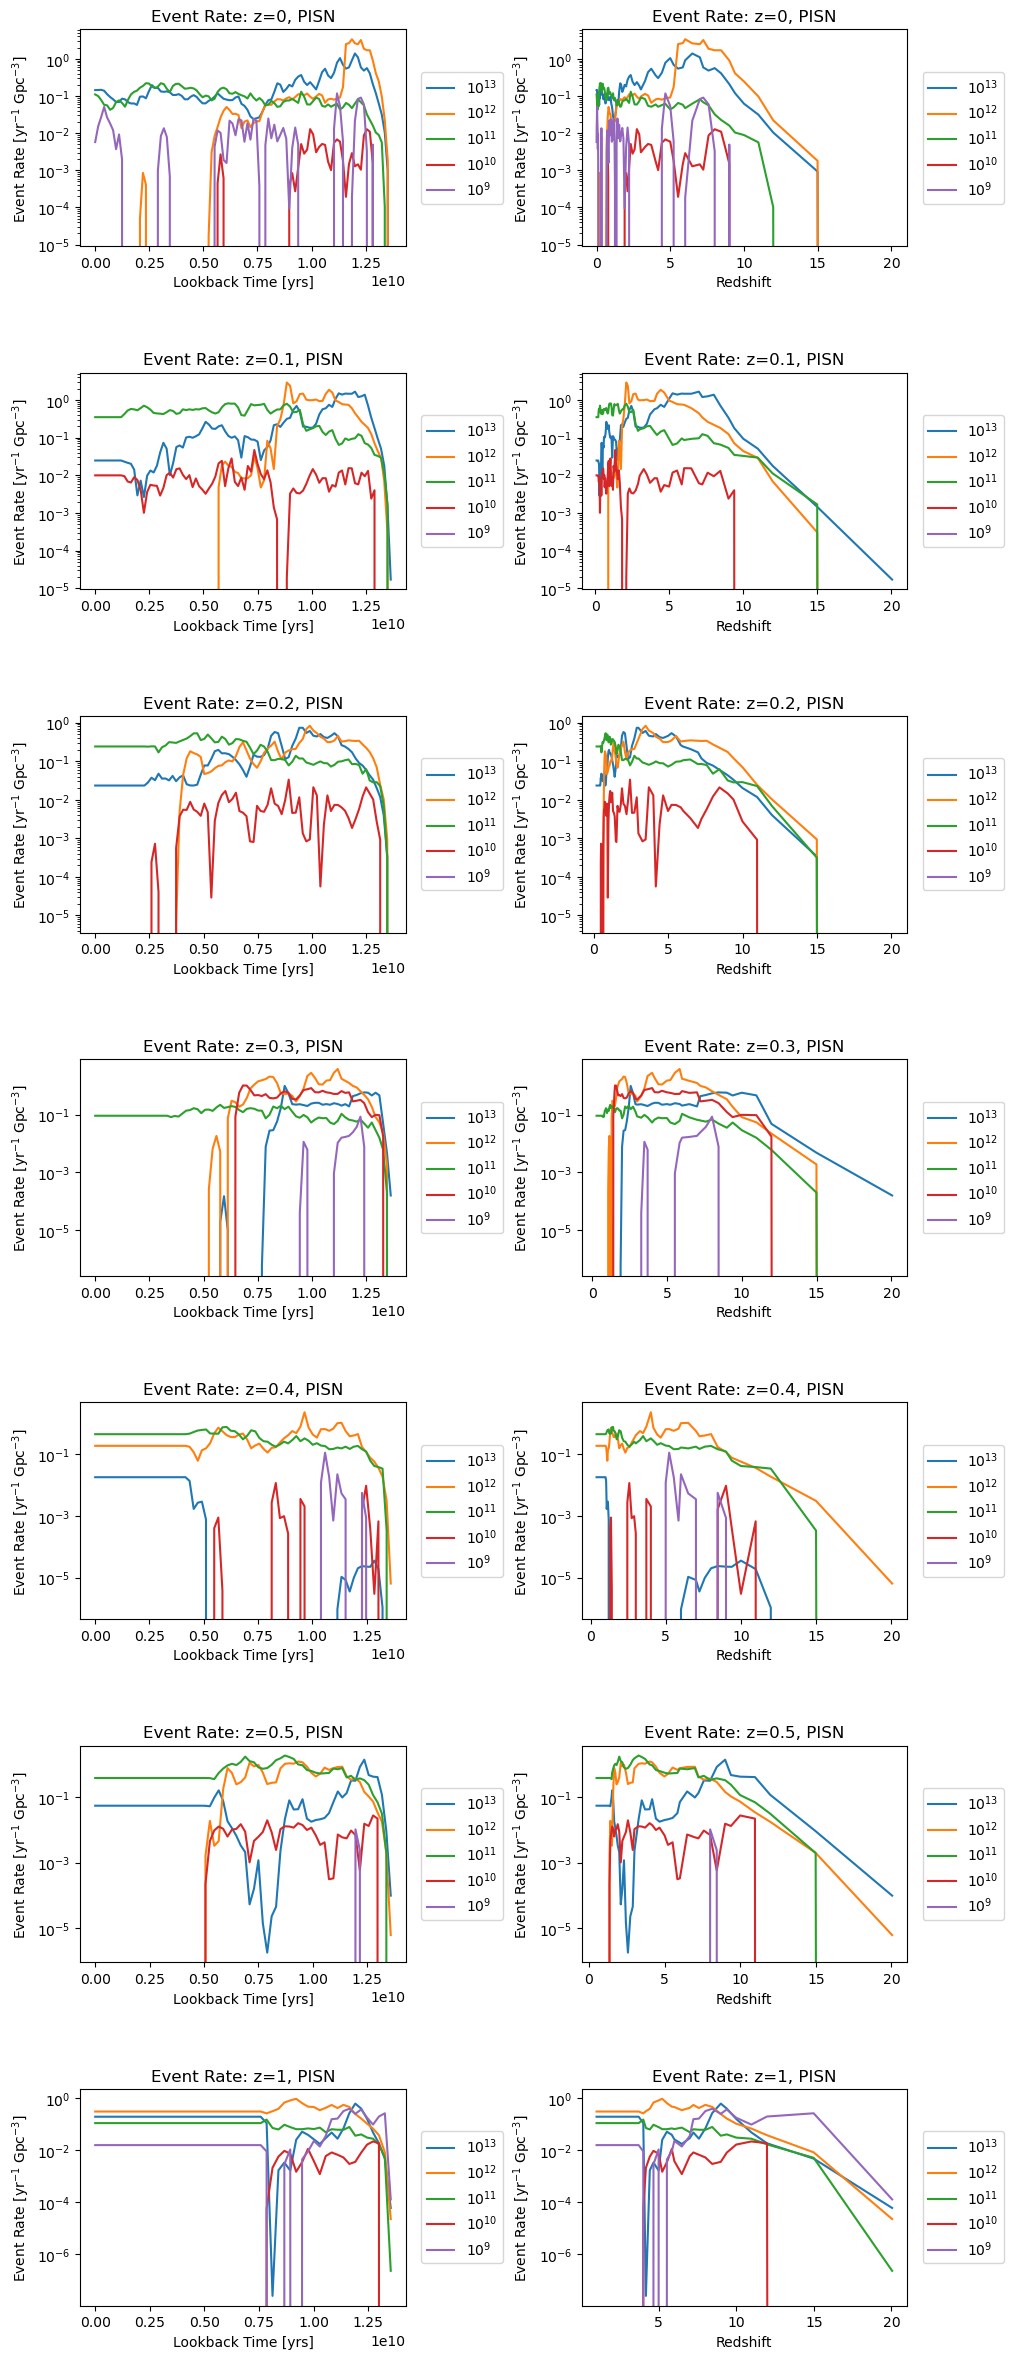

In [39]:
# PISN

figure, axis = plt.subplots(7, 2, figsize=(11, 25))
figure.tight_layout(pad=7.0)

# z=0, snapshot=99
axis[0,0].plot(edges2_99, out2_99[:,6][0], label='10$^{13}$')
axis[0,0].plot(edges3_99, out3_99[:,6][0], label='10$^{12}$')
axis[0,0].plot(edges4_99, out4_99[:,6][0], label='10$^{11}$')
axis[0,0].plot(edges5_99, out5_99[:,6][0], label='10$^{10}$')
axis[0,0].plot(edges6_99, out6_99[:,6][0], label='10$^{9}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0, PISN")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'], out2_99[:,6][0], label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'], out3_99[:,6][0], label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'], out4_99[:,6][0], label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'], out5_99[:,6][0], label='10$^{10}$')
axis[0,1].plot(SFH.attrs['redshift'], out6_99[:,6][0], label='10$^{9}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0, PISN")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.1, snapshot=91
axis[1,0].plot(edges2_91, out2_91[:,6][0], label='10$^{13}$')
axis[1,0].plot(edges3_91, out3_91[:,6][0], label='10$^{12}$')
axis[1,0].plot(edges4_91, out4_91[:,6][0], label='10$^{11}$')
axis[1,0].plot(edges5_91, out5_91[:,6][0], label='10$^{10}$')
axis[1,0].plot(edges6_91, out6_91[:,6][0], label='10$^{9}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.1, PISN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,6][0], label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,6][0], label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,6][0], label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,6][0], label='10$^{10}$')
axis[1,1].plot(SFH.attrs['redshift'][8:], out6_91[:,6][0], label='10$^{9}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.1, PISN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.2, snapshot=84
axis[2,0].plot(edges2_84, out2_84[:,6][0], label='10$^{13}$')
axis[2,0].plot(edges3_84, out3_84[:,6][0], label='10$^{12}$')
axis[2,0].plot(edges4_84, out4_84[:,6][0], label='10$^{11}$')
axis[2,0].plot(edges5_84, out5_84[:,6][0], label='10$^{10}$')
axis[2,0].plot(edges6_84, out6_84[:,6][0], label='10$^{9}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=0.2, PISN")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][15:], out2_84[:,6][0], label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out3_84[:,6][0], label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out4_84[:,6][0], label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out5_84[:,6][0], label='10$^{10}$')
axis[2,1].plot(SFH.attrs['redshift'][15:], out6_84[:,6][0], label='10$^{9}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=0.2, PISN")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.3, snapshot=78
axis[3,0].plot(edges2_78, out2_78[:,6][0], label='10$^{13}$')
axis[3,0].plot(edges3_78, out3_78[:,6][0], label='10$^{12}$')
axis[3,0].plot(edges4_78, out4_78[:,6][0], label='10$^{11}$')
axis[3,0].plot(edges5_78, out5_78[:,6][0], label='10$^{10}$')
axis[3,0].plot(edges6_78, out6_78[:,6][0], label='10$^{9}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=0.3, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][21:], out2_78[:,6][0], label='10$^{13}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out3_78[:,6][0], label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out4_78[:,6][0], label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out5_78[:,6][0], label='10$^{10}$')
axis[3,1].plot(SFH.attrs['redshift'][21:], out6_78[:,6][0], label='10$^{9}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=0.3, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.4, snapshot=72
axis[4,0].plot(edges2_72, out2_72[:,6][0], label='10$^{13}$')
axis[4,0].plot(edges3_72, out3_72[:,6][0], label='10$^{12}$')
axis[4,0].plot(edges4_72, out4_72[:,6][0], label='10$^{11}$')
axis[4,0].plot(edges5_72, out5_72[:,6][0], label='10$^{10}$')
axis[4,0].plot(edges6_72, out6_72[:,6][0], label='10$^{9}$')
axis[4,0].set_yscale('log')
axis[4,0].set_xlabel('Lookback Time [yrs]')
axis[4,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,0].set_title(r"Event Rate: z=0.4, PISN")
pos = axis[4,0].get_position()
axis[4,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[4,1].plot(SFH.attrs['redshift'][27:], out2_72[:,6][0], label='10$^{13}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out3_72[:,6][0], label='10$^{12}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out4_72[:,6][0], label='10$^{11}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out5_72[:,6][0], label='10$^{10}$')
axis[4,1].plot(SFH.attrs['redshift'][27:], out6_72[:,6][0], label='10$^{9}$')
axis[4,1].set_yscale('log')
axis[4,1].set_xlabel('Redshift')
axis[4,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[4,1].set_title(r"Event Rate: z=0.4, PISN")
pos = axis[4,1].get_position()
axis[4,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[4,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[5,0].plot(edges2_67, out2_67[:,6][0], label='10$^{13}$')
axis[5,0].plot(edges3_67, out3_67[:,6][0], label='10$^{12}$')
axis[5,0].plot(edges4_67, out4_67[:,6][0], label='10$^{11}$')
axis[5,0].plot(edges5_67, out5_67[:,6][0], label='10$^{10}$')
axis[5,0].plot(edges6_67, out6_67[:,6][0], label='10$^{9}$')
axis[5,0].set_yscale('log')
axis[5,0].set_xlabel('Lookback Time [yrs]')
axis[5,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,0].set_title(r"Event Rate: z=0.5, PISN")
pos = axis[5,0].get_position()
axis[5,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[5,1].plot(SFH.attrs['redshift'][32:], out2_67[:,6][0], label='10$^{13}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out3_67[:,6][0], label='10$^{12}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out4_67[:,6][0], label='10$^{11}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out5_67[:,6][0], label='10$^{10}$')
axis[5,1].plot(SFH.attrs['redshift'][32:], out6_67[:,6][0], label='10$^{9}$')
axis[5,1].set_yscale('log')
axis[5,1].set_xlabel('Redshift')
axis[5,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[5,1].set_title(r"Event Rate: z=0.5, PISN")
pos = axis[5,1].get_position()
axis[5,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[5,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[6,0].plot(edges2_50, out2_50[:,6][0], label='10$^{13}$')
axis[6,0].plot(edges3_50, out3_50[:,6][0], label='10$^{12}$')
axis[6,0].plot(edges4_50, out4_50[:,6][0], label='10$^{11}$')
axis[6,0].plot(edges5_50, out5_50[:,6][0], label='10$^{10}$')
axis[6,0].plot(edges6_50, out6_50[:,6][0], label='10$^{9}$')
axis[6,0].set_yscale('log')
axis[6,0].set_xlabel('Lookback Time [yrs]')
axis[6,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,0].set_title(r"Event Rate: z=1, PISN")
pos = axis[6,0].get_position()
axis[6,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[6,1].plot(SFH.attrs['redshift'][49:], out2_50[:,6][0], label='10$^{13}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out3_50[:,6][0], label='10$^{12}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out4_50[:,6][0], label='10$^{11}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out5_50[:,6][0], label='10$^{10}$')
axis[6,1].plot(SFH.attrs['redshift'][49:], out6_50[:,6][0], label='10$^{9}$')
axis[6,1].set_yscale('log')
axis[6,1].set_xlabel('Redshift')
axis[6,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[6,1].set_title(r"Event Rate: z=1, PISN")
pos = axis[6,1].get_position()
axis[6,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[6,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [ ]:
# summing over redshifts

In [40]:
typeIa_mass2 = [sum(x) for x in zip_longest(out2_99[:,0][0], out2_91[:,0][0], out2_84[:,0][0], out2_78[:,0][0], out2_72[:,0][0], 
                                            out2_67[:,0][0], out2_50[:,0][0], fillvalue=0)]
typeIa_mass3 = [sum(x) for x in zip_longest(out3_99[:,0][0], out3_91[:,0][0], out3_84[:,0][0], out3_78[:,0][0], out3_72[:,0][0], 
                                            out3_67[:,0][0], out3_50[:,0][0], fillvalue=0)]
typeIa_mass4 = [sum(x) for x in zip_longest(out4_99[:,0][0], out4_91[:,0][0], out4_84[:,0][0], out4_78[:,0][0], out4_72[:,0][0], 
                                            out4_67[:,0][0], out4_50[:,0][0], fillvalue=0)]
typeIa_mass5 = [sum(x) for x in zip_longest(out5_99[:,0][0], out5_91[:,0][0], out5_84[:,0][0], out5_78[:,0][0], out5_72[:,0][0], 
                                            out5_67[:,0][0], out5_50[:,0][0], fillvalue=0)]
typeIa_mass6 = [sum(x) for x in zip_longest(out6_99[:,0][0], out6_91[:,0][0], out6_84[:,0][0], out6_78[:,0][0], out6_72[:,0][0], 
                                            out6_67[:,0][0], out6_50[:,0][0], fillvalue=0)]

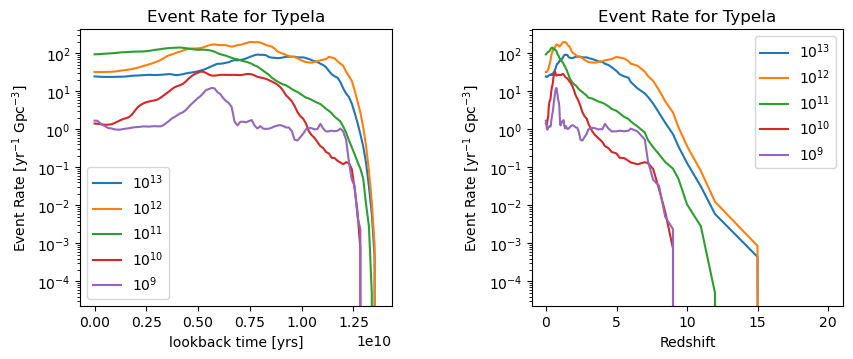

In [41]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
figure.tight_layout(pad=7.0)

axis[0].plot(edges2_99, typeIa_mass2, label='10$^{13}$')
axis[0].plot(edges3_99, typeIa_mass3, label='10$^{12}$')
axis[0].plot(edges4_99, typeIa_mass4, label='10$^{11}$')
axis[0].plot(edges5_99, typeIa_mass5, label='10$^{10}$')
axis[0].plot(edges6_99, typeIa_mass6, label='10$^{9}$')
axis[0].set_yscale('log')
axis[0].set_xlabel('lookback time [yrs]')
axis[0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0].set_title(r"Event Rate for TypeIa")
axis[0].legend()

axis[1].plot(SFH.attrs['redshift'], typeIa_mass2, label='10$^{13}$')
axis[1].plot(SFH.attrs['redshift'], typeIa_mass3, label='10$^{12}$')
axis[1].plot(SFH.attrs['redshift'], typeIa_mass4, label='10$^{11}$')
axis[1].plot(SFH.attrs['redshift'], typeIa_mass5, label='10$^{10}$')
axis[1].plot(SFH.attrs['redshift'], typeIa_mass6, label='10$^{9}$')
axis[1].set_yscale('log')
axis[1].set_xlabel('Redshift')
axis[1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1].set_title(r"Event Rate for TypeIa")
axis[1].legend()

In [42]:
CCSN_mass2 = [sum(x) for x in zip_longest(out2_99[:,1:5][0].sum(axis=0), out2_91[:,1:5][0].sum(axis=0), out2_84[:,1:5][0].sum(axis=0),
                                          out2_78[:,1:5][0].sum(axis=0), out2_72[:,1:5][0].sum(axis=0), out2_67[:,1:5][0].sum(axis=0), 
                                          out2_50[:,1:5][0].sum(axis=0), fillvalue=0)]
CCSN_mass3 = [sum(x) for x in zip_longest(out3_99[:,1:5][0].sum(axis=0), out3_91[:,1:5][0].sum(axis=0), out3_84[:,1:5][0].sum(axis=0),
                                          out3_78[:,1:5][0].sum(axis=0), out3_72[:,1:5][0].sum(axis=0), out3_67[:,1:5][0].sum(axis=0),
                                          out3_50[:,1:5][0].sum(axis=0), fillvalue=0)]
CCSN_mass4 = [sum(x) for x in zip_longest(out4_99[:,1:5][0].sum(axis=0), out4_91[:,1:5][0].sum(axis=0), out4_84[:,1:5][0].sum(axis=0),
                                          out4_78[:,1:5][0].sum(axis=0), out4_72[:,1:5][0].sum(axis=0), out4_67[:,1:5][0].sum(axis=0),
                                          out4_50[:,1:5][0].sum(axis=0), fillvalue=0)]
CCSN_mass5 = [sum(x) for x in zip_longest(out5_99[:,1:5][0].sum(axis=0), out5_91[:,1:5][0].sum(axis=0), out5_84[:,1:5][0].sum(axis=0),
                                          out5_78[:,1:5][0].sum(axis=0), out5_72[:,1:5][0].sum(axis=0), out5_67[:,1:5][0].sum(axis=0),
                                          out5_50[:,1:5][0].sum(axis=0), fillvalue=0)]
CCSN_mass6 = [sum(x) for x in zip_longest(out6_99[:,1:5][0].sum(axis=0), out6_91[:,1:5][0].sum(axis=0), out6_84[:,1:5][0].sum(axis=0),
                                          out6_78[:,1:5][0].sum(axis=0), out6_72[:,1:5][0].sum(axis=0), out6_67[:,1:5][0].sum(axis=0),
                                          out6_50[:,1:5][0].sum(axis=0), fillvalue=0)]

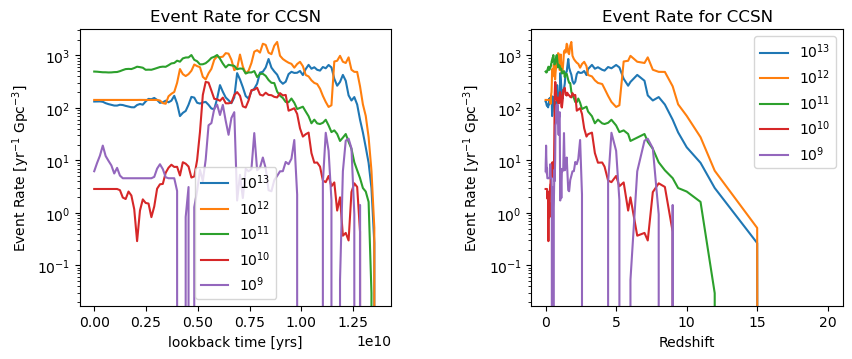

In [43]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
figure.tight_layout(pad=7.0)

axis[0].plot(edges2_99, CCSN_mass2, label='10$^{13}$')
axis[0].plot(edges3_99, CCSN_mass3, label='10$^{12}$')
axis[0].plot(edges4_99, CCSN_mass4, label='10$^{11}$')
axis[0].plot(edges5_99, CCSN_mass5, label='10$^{10}$')
axis[0].plot(edges6_99, CCSN_mass6, label='10$^{9}$')
axis[0].set_yscale('log')
axis[0].set_xlabel('lookback time [yrs]')
axis[0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0].set_title(r"Event Rate for CCSN")
axis[0].legend()

axis[1].plot(SFH.attrs['redshift'], CCSN_mass2, label='10$^{13}$')
axis[1].plot(SFH.attrs['redshift'], CCSN_mass3, label='10$^{12}$')
axis[1].plot(SFH.attrs['redshift'], CCSN_mass4, label='10$^{11}$')
axis[1].plot(SFH.attrs['redshift'], CCSN_mass5, label='10$^{10}$')
axis[1].plot(SFH.attrs['redshift'], CCSN_mass6, label='10$^{9}$')
axis[1].set_yscale('log')
axis[1].set_xlabel('Redshift')
axis[1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1].set_title(r"Event Rate for CCSN")
axis[1].legend()

In [44]:
LGRB_mass2 = [sum(x) for x in zip_longest(out2_99[:,5][0], out2_91[:,5][0], out2_84[:,5][0], out2_78[:,5][0], out2_72[:,5][0], out2_67[:,5][0],
                                          out2_50[:,5][0], fillvalue=0)]
LGRB_mass3 = [sum(x) for x in zip_longest(out3_99[:,5][0], out3_91[:,5][0], out3_84[:,5][0], out3_78[:,5][0], out3_72[:,5][0], out3_67[:,5][0],
                                          out3_50[:,5][0], fillvalue=0)]
LGRB_mass4 = [sum(x) for x in zip_longest(out4_99[:,5][0], out4_91[:,5][0], out4_84[:,5][0], out4_78[:,5][0], out4_72[:,5][0], out4_67[:,5][0],
                                          out4_50[:,5][0], fillvalue=0)]
LGRB_mass5 = [sum(x) for x in zip_longest(out5_99[:,5][0], out5_91[:,5][0], out5_84[:,5][0], out5_78[:,5][0], out5_72[:,5][0], out5_67[:,5][0],
                                          out5_50[:,5][0], fillvalue=0)]
LGRB_mass6 = [sum(x) for x in zip_longest(out6_99[:,5][0], out6_91[:,5][0], out6_84[:,5][0], out6_78[:,5][0], out6_72[:,5][0], out6_67[:,5][0],
                                          out6_50[:,5][0], fillvalue=0)]

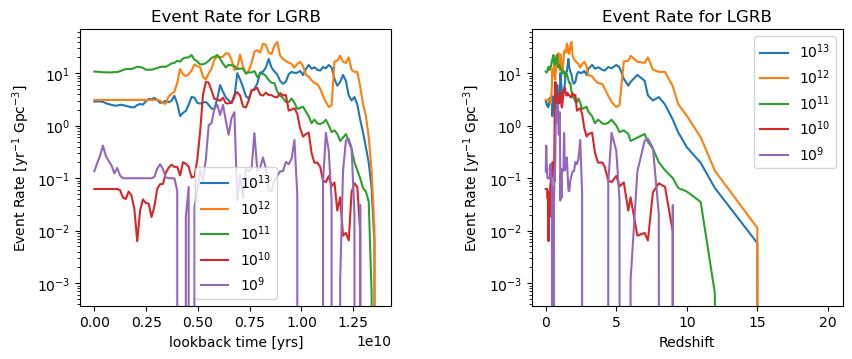

In [45]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
figure.tight_layout(pad=7.0)

axis[0].plot(edges2_99, LGRB_mass2, label='10$^{13}$')
axis[0].plot(edges3_99, LGRB_mass3, label='10$^{12}$')
axis[0].plot(edges4_99, LGRB_mass4, label='10$^{11}$')
axis[0].plot(edges5_99, LGRB_mass5, label='10$^{10}$')
axis[0].plot(edges6_99, LGRB_mass6, label='10$^{9}$')
axis[0].set_yscale('log')
axis[0].set_xlabel('lookback time [yrs]')
axis[0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0].set_title(r"Event Rate for LGRB")
axis[0].legend()

axis[1].plot(SFH.attrs['redshift'], LGRB_mass2, label='10$^{13}$')
axis[1].plot(SFH.attrs['redshift'], LGRB_mass3, label='10$^{12}$')
axis[1].plot(SFH.attrs['redshift'], LGRB_mass4, label='10$^{11}$')
axis[1].plot(SFH.attrs['redshift'], LGRB_mass5, label='10$^{10}$')
axis[1].plot(SFH.attrs['redshift'], LGRB_mass6, label='10$^{9}$')
axis[1].set_yscale('log')
axis[1].set_xlabel('Redshift')
axis[1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1].set_title(r"Event Rate for LGRB")
axis[1].legend()

In [46]:
PISN_mass2 = [sum(x) for x in zip_longest(out2_99[:,6][0], out2_91[:,6][0], out2_84[:,6][0], out2_78[:,6][0], out2_72[:,6][0], out2_67[:,6][0],
                                          out2_50[:,6][0], fillvalue=0)]
PISN_mass3 = [sum(x) for x in zip_longest(out3_99[:,6][0], out3_91[:,6][0], out3_84[:,6][0], out3_78[:,6][0], out3_72[:,6][0], out3_67[:,6][0],
                                          out3_50[:,6][0], fillvalue=0)]
PISN_mass4 = [sum(x) for x in zip_longest(out4_99[:,6][0], out4_91[:,6][0], out4_84[:,6][0], out4_78[:,6][0], out4_72[:,6][0], out4_67[:,6][0],
                                          out4_50[:,6][0], fillvalue=0)]
PISN_mass5 = [sum(x) for x in zip_longest(out5_99[:,6][0], out5_91[:,6][0], out5_84[:,6][0], out5_78[:,6][0], out5_72[:,6][0], out5_67[:,6][0],
                                          out5_50[:,6][0], fillvalue=0)]
PISN_mass6 = [sum(x) for x in zip_longest(out6_99[:,6][0], out6_91[:,6][0], out6_84[:,6][0], out6_78[:,6][0], out6_72[:,6][0], out6_67[:,6][0],
                                          out6_50[:,6][0], fillvalue=0)]

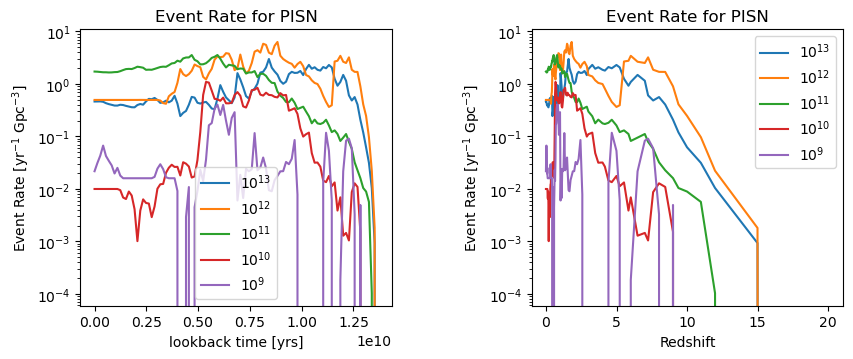

In [47]:
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
figure.tight_layout(pad=7.0)

axis[0].plot(edges2_99, PISN_mass2, label='10$^{13}$')
axis[0].plot(edges3_99, PISN_mass3, label='10$^{12}$')
axis[0].plot(edges4_99, PISN_mass4, label='10$^{11}$')
axis[0].plot(edges5_99, PISN_mass5, label='10$^{10}$')
axis[0].plot(edges6_99, PISN_mass6, label='10$^{9}$')
axis[0].set_yscale('log')
axis[0].set_xlabel('lookback time [yrs]')
axis[0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0].set_title(r"Event Rate for PISN")
axis[0].legend()

axis[1].plot(SFH.attrs['redshift'], PISN_mass2, label='10$^{13}$')
axis[1].plot(SFH.attrs['redshift'], PISN_mass3, label='10$^{12}$')
axis[1].plot(SFH.attrs['redshift'], PISN_mass4, label='10$^{11}$')
axis[1].plot(SFH.attrs['redshift'], PISN_mass5, label='10$^{10}$')
axis[1].plot(SFH.attrs['redshift'], PISN_mass6, label='10$^{9}$')
axis[1].set_yscale('log')
axis[1].set_xlabel('Redshift')
axis[1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1].set_title(r"Event Rate for PISN")
axis[1].legend()